# Basic Exploratory Data Analysis and Word Analysis

## 1. Introduction

Exploratory Data Analysis (EDA) is an iterative process with multiple stages, types, tools and techniques, the overall objective being to obtain actionable insights which can inform data-driven decision-making. It is a way of exploring data through statistical summaries and graphical representations to identify trends and patterns, and test assumptions. It also informs further requirements for cleaning and feature engineering.

Basic EDA will be performed to analyse text statistics, followed by Word Analysis which will use spaCy to analyse stopwords and n-grams. Outputs will be visualised as histograms, bar charts and wordclouds.












## 2. Install/import libraries

In [ ]:
!pip install spacy scispacy textstat

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_sm-0.5.3.tar.gz

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import pickle
import spacy
import scispacy
import textstat
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor
from wordcloud import WordCloud
from textstat import flesch_reading_ease

from spacy.lang.en import stop_words
from spacy.language import Language
from spacy.tokens import Doc
from spacy.matcher import Matcher
from spacy.attrs import ORTH
from spacy.tokenizer import Tokenizer

## 3. Import data

In [ ]:
with open('2023-02-18_pmc_arxiv_full_text_merged_plus.pickle', 'rb') as f:
    pmc_arxiv_full_text_merged_plus = pickle.load(f)

## 4. Basic EDA

During the data collection, cleaning and integration stages some EDA was performed by identifying missing and duplicate values and dropping rows for which full text was not available.

In [ ]:
pmc_arxiv_full_text_merged_plus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11693 entries, 0 to 11692
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  11693 non-null  object
 1   published   11693 non-null  object
 2   revised     11693 non-null  object
 3   title       11693 non-null  object
 4   journal     11432 non-null  object
 5   authors     11693 non-null  object
 6   doi         11456 non-null  object
 7   pdf_url     11693 non-null  object
 8   text        11693 non-null  object
dtypes: object(9)
memory usage: 822.3+ KB


We have already accounted for the journal reference and DOI null values for arXiv data as in most cases submissions are not yet published so this information will be added by the authors at a later date.

In [ ]:
pmc_arxiv_full_text_merged_plus.head(5)

article_id   published     revised  \
0  PMC9549161  2022-09-26  2022-10-14   
1  PMC9539342  2022-09-22  2022-11-12   
2  PMC9357751  2022-12-01  2022-12-05   
3  PMC9346052  2022-08-03  2022-09-05   
4  PMC9775208  2022-12-15  2022-12-25   

                                               title  \
0       Drug repositioning: A bibliometric analysis.   
1  A review on computer-aided chemogenomics and d...   
2  Repurposing Molnupiravir as a new opportunity ...   
3  Scope of repurposed drugs against the potentia...   
4  Drug Repurposing Using Gene Co-Expression and ...   

                                             journal  \
0                          Frontiers in pharmacology   
1                     Chemical biology & drug design   
2  Journal of Generic Medicines : Duplicate, mark...   
3                               Structural chemistry   
4                                            Biology   

                                             authors  \
0  Sun G, Dong D, Dong Z, Zhang Q, Fang H, Wang C...   
1  Maghsoudi S, Taghavi Shahraki B, Rameh F, Naza...   
2                                                  0   
3  Niranjan V, Setlur AS, Karunakaran C, Uttarkar...   
4                                Mailem RC, Tayo LL.   

                          doi  \
0   10.3389/fphar.2022.974849   
1          10.1111/cbdd.14136   
2                           0   
3  10.1007/s11224-022-02020-z   
4     10.3390/biology11121827   

                                             pdf_url  \
0  https://europepmc.org/articles/PMC9549161?pdf=...   
1  https://europepmc.org/articles/PMC9539342?pdf=...   
2  https://europepmc.org/articles/PMC9357751?pdf=...   
3  https://europepmc.org/articles/PMC9346052?pdf=...   
4  https://europepmc.org/articles/PMC9775208?pdf=...   

                                                text  
0  Sir James Black, a winner of the 1988 Nobel Pr...  
1  Tight and selective interaction between ligand...  
2  The severe acute respiratory syndrome coronavi...  
3  The sudden outbreak of SARS-CoV-2 in 2019 took...  
4  The 2019 novel coronavirus, now dubbed SARS-Co...

### 4.1 Journal counts
Return a Series containing counts of unique values for journal titles.

In [ ]:
pmc_arxiv_full_text_merged_plus['journal'].value_counts()

Frontiers in pharmacology                                                                                      464
Molecules (Basel, Switzerland)                                                                                 334
Scientific reports                                                                                             329
International journal of molecular sciences                                                                    297
Journal of biomolecular structure & dynamics                                                                   187
                                                                                                              ... 
RNA biology                                                                                                      1
Bulletin of Materials Science                                                                                    1
Clinical obesity                                                                

There are 1900 journal titles in which the 11,693 articles are published.

Print out the journal titles and counts.

In [ ]:
journal_counts  = pmc_arxiv_full_text_merged_plus.groupby(pmc_arxiv_full_text_merged_plus['journal'])

i = 1

print('=========== Journal Count ===========\n')

for journal_title, journal_count in journal_counts:
    print('Journal Title: ' + str(i) + ' ' + journal_title + ': ' + str(len(journal_count)))
    i = i+1

print('\n====================================')

=========== Journal Count ===========

Journal Title: 1 3 Biotech: 17
Journal Title: 2 AAAI 2022: 1
Journal Title: 3 AAPS PharmSciTech: 5
Journal Title: 4 AAPS open: 1
Journal Title: 5 ACM SIGKDD International Conference on Knowledge Discovery & Data
  Mining 2021: 1
Journal Title: 6 ACS applied bio materials: 2
Journal Title: 7 ACS applied materials & interfaces: 3
Journal Title: 8 ACS applied nano materials: 1
Journal Title: 9 ACS bio & med chem Au: 2
Journal Title: 10 ACS biomaterials science & engineering: 5
Journal Title: 11 ACS catalysis: 3
Journal Title: 12 ACS central science: 12
Journal Title: 13 ACS chemical biology: 6
Journal Title: 14 ACS chemical neuroscience: 1
Journal Title: 15 ACS combinatorial science: 2
Journal Title: 16 ACS infectious diseases: 33
Journal Title: 17 ACS measurement science au: 1
Journal Title: 18 ACS medicinal chemistry letters: 13
Journal Title: 19 ACS nano: 5
Journal Title: 20 ACS nanoscience Au: 1
Journal Title: 21 ACS omega: 62
Journal Title: 22 A

Filter for journals with more than one article.

In [ ]:
filtered_journal_counts = journal_counts.filter(lambda x:x.shape[0] > 1)

final_journal_counts = filtered_journal_counts.groupby(filtered_journal_counts['journal'])

i=1

print('============ Reduced Journal Titles ============\n')

for journal_title, journal_count in final_journal_counts:
    print('Journal Title:' + str(i) + ' ' + journal_title + ': '+ str(len(journal_count)))
    i = i+1

print('\n===============================================')

============ Reduced Journal Titles ============

Journal Title:1 3 Biotech: 17
Journal Title:2 AAPS PharmSciTech: 5
Journal Title:3 ACS applied bio materials: 2
Journal Title:4 ACS applied materials & interfaces: 3
Journal Title:5 ACS bio & med chem Au: 2
Journal Title:6 ACS biomaterials science & engineering: 5
Journal Title:7 ACS catalysis: 3
Journal Title:8 ACS central science: 12
Journal Title:9 ACS chemical biology: 6
Journal Title:10 ACS combinatorial science: 2
Journal Title:11 ACS infectious diseases: 33
Journal Title:12 ACS medicinal chemistry letters: 13
Journal Title:13 ACS nano: 5
Journal Title:14 ACS omega: 62
Journal Title:15 ACS pharmacology & translational science: 19
Journal Title:16 ACS synthetic biology: 3
Journal Title:17 AI & society: 2
Journal Title:18 AI and ethics: 2
Journal Title:19 AMB Express: 4
Journal Title:20 APL bioengineering: 4
Journal Title:21 Accounts of chemical research: 2
Journal Title:22 Acta crystallographica. Section D, Structural biology: 11
J

In [ ]:
print(str(len(filtered_journal_counts)) + ' ' + 'articles in' + ' ' + str(len(final_journal_counts)) + ' ' + 'journals')

10541 articles in 1009 journals


Filter further for journals with > 50 articles.

In [ ]:
filtered_journal_counts = journal_counts.filter(lambda x:x.shape[0] > 50)

final_journal_counts = filtered_journal_counts.groupby(filtered_journal_counts['journal'])

i=1

print('============ Reduced Journal Titles ============\n')

for journal_title, journal_count in final_journal_counts:
    print('Journal Title:' + str(i) + ' ' + journal_title + ': '+ str(len(journal_count)))
    i = i+1

print('\n===============================================')

============ Reduced Journal Titles ============

Journal Title:1 ACS omega: 62
Journal Title:2 Alzheimer's & dementia (Amsterdam, Netherlands): 51
Journal Title:3 Alzheimer's research & therapy: 63
Journal Title:4 Biomedicines: 58
Journal Title:5 Biomolecules: 88
Journal Title:6 Briefings in bioinformatics: 86
Journal Title:7 Cells: 75
Journal Title:8 Computational and structural biotechnology journal: 57
Journal Title:9 Computers in biology and medicine: 97
Journal Title:10 Drug discovery today: 76
Journal Title:11 Frontiers in aging neuroscience: 92
Journal Title:12 Frontiers in cell and developmental biology: 51
Journal Title:13 Frontiers in cellular and infection microbiology: 62
Journal Title:14 Frontiers in chemistry: 67
Journal Title:15 Frontiers in genetics: 52
Journal Title:16 Frontiers in immunology: 102
Journal Title:17 Frontiers in microbiology: 82
Journal Title:18 Frontiers in molecular biosciences: 84
Journal Title:19 Frontiers in neuroscience: 55
Journal Title:20 Fronti

In [ ]:
print(str(len(filtered_journal_counts)) + ' ' + 'articles in' + ' ' + str(len(final_journal_counts)) + ' ' + 'journals')

3933 articles in 34 journals


Countplot for the 34 journals showing article counts in descending order.



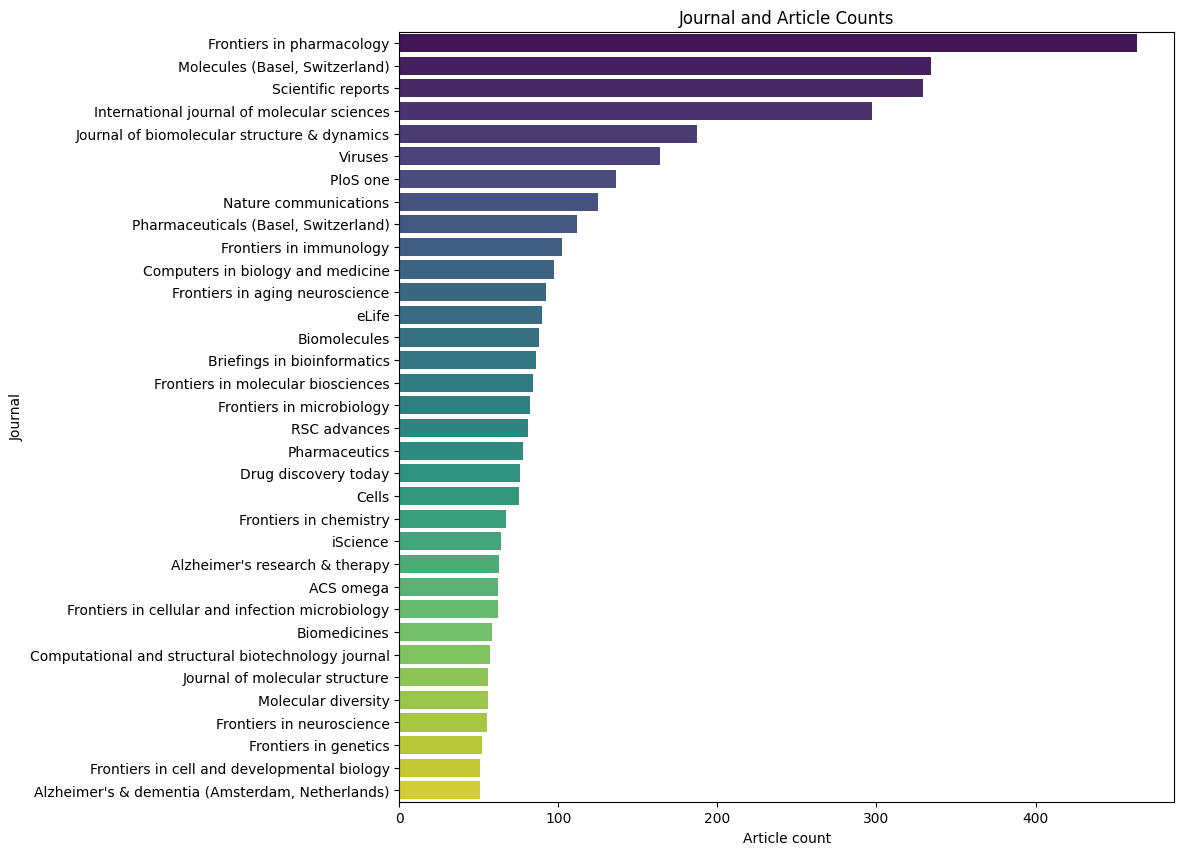

In [ ]:
plt.figure(figsize=(10, 10))

sns.countplot(y='journal', data=filtered_journal_counts, order=filtered_journal_counts['journal'].value_counts().index, palette='viridis')
plt.title('Journal and Article Counts')
plt.xlabel('Article count')
plt.ylabel('Journal')

plt.show()


We can clearly see that 'Frontiers in Pharmacology' is the journal with the most articles for our search query. It is the most cited pharmacology and pharmacy journal and publishes research on disease treatment and drug effects.

Print article titles for journal counts in descending order.

In [ ]:
print('============ Reduced Journal Titles and Article Titles ============\n')

# Sort final_journal_counts based on counts in descending order
sorted_journal_counts = sorted(final_journal_counts, key=lambda x: len(x[1]), reverse=True)

i = 1

# Regular expression pattern to match XML tags
xml_tags_pattern = re.compile(r'<.*?>')

for journal_title, journal_count in sorted_journal_counts:
    print(f'Journal Title: {i} {journal_title}: {len(journal_count)}\n')

    article_title_list = journal_count['title'].tolist()
    for j, article_title in enumerate(article_title_list, start=1):
        # Remove all XML tags from the article title
        cleaned_article_title = re.sub(xml_tags_pattern, '', article_title)
        print(f'Article Title {j}: {cleaned_article_title}')

    print('==============================================================\n')
    i += 1


============ Reduced Journal Titles and Article Titles ============

Journal Title: 1 Frontiers in pharmacology: 464

Article Title 1: Drug repositioning: A bibliometric analysis.
Article Title 2: Drug Repositioning with GraphSAGE and Clustering Constraints Based on Drug and Disease Networks.
Article Title 3: Structures of the SARS-CoV-2 spike glycoprotein and applications for novel drug development.
Article Title 4: The Anti-Histamine Azelastine, Identified by Computational Drug Repurposing, Inhibits Infection by Major Variants of SARS-CoV-2 in Cell Cultures and Reconstituted Human Nasal Tissue.
Article Title 5: Network pharmacology reveals multitarget mechanism of action of drugs to be repurposed for COVID-19.
Article Title 6: Optimal COVID-19 therapeutic candidate discovery using the CANDO platform.
Article Title 7: Screening of potential inhibitors targeting the main protease structure of SARS-CoV-2 via molecular docking.
Article Title 8: Selective serotonin reuptake inhibitors: Ne

We will define a function to remove XML tags from the article titles, for terms such as *in silico* and *in vitro*, and other formatting such as superscript and subscript. We have already removed tags from full text in previous stages. However, we can see that there are other issues such as inconsistent hyphenation (e.g. SARS CoV-2, SARS-CoV-2) which will have to be normalised.

In [ ]:
def cleaned_article_titles(df):
    """
    Regular expression pattern to match XML tags
    and extract cleaned article titles as a list
    """
    cleaned_titles = df['title'].apply(lambda x: re.sub(r'<.*?>', '', x)).tolist()

    return cleaned_titles

In [ ]:
cleaned_article_titles = cleaned_article_titles(pmc_arxiv_full_text_merged_plus)

In [ ]:
len(cleaned_article_titles)

11693

In [ ]:
cleaned_article_titles[:10]

['Drug repositioning: A bibliometric analysis.',
 'A review on computer-aided chemogenomics and drug repositioning for rational COVID-19 drug discovery.',
 'Repurposing Molnupiravir as a new opportunity to treat COVID-19',
 'Scope of repurposed drugs against the potential targets of the latest variants of SARS-CoV-2.',
 'Drug Repurposing Using Gene Co-Expression and Module Preservation Analysis in Acute Respiratory Distress Syndrome (ARDS), Systemic Inflammatory Response Syndrome (SIRS), Sepsis, and COVID-19.',
 'Novel Drug Design for Treatment of COVID-19: A Systematic Review of Preclinical Studies.',
 'Repurposing FDA-approved drugs cetilistat, abiraterone, diiodohydroxyquinoline, bexarotene, and remdesivir as potential inhibitors against RNA dependent RNA polymerase of SARS-CoV-2: A comparative in silico perspective.',
 'A comprehensive review of artificial intelligence and network based approaches to drug repurposing in Covid-19.',
 'Structural Homology-Based Drug Repurposing Appro

In [ ]:
with open('2024-02-03_cleaned_article_titles.pickle', 'wb') as f:
  pickle.dump(cleaned_article_titles, f)

Add cleaned article titles column to DataFrame.

In [ ]:
pmc_arxiv_full_text_merged_plus_cleaned_article_titles = pmc_arxiv_full_text_merged_plus.copy()

In [ ]:
pmc_arxiv_full_text_merged_plus_cleaned_article_titles['title_cleaned'] = cleaned_article_titles

Reposition cleaned article titles column.

In [ ]:
pmc_arxiv_full_text_merged_plus_cleaned_article_titles.insert(4, 'title_cleaned', pmc_arxiv_full_text_merged_plus_cleaned_article_titles.pop('title_cleaned'))

In [ ]:
pmc_arxiv_full_text_merged_plus_cleaned_article_titles.head(1)

article_id   published     revised  \
0  PMC9549161  2022-09-26  2022-10-14   

                                          title  \
0  Drug repositioning: A bibliometric analysis.   

                                  title_cleaned                    journal  \
0  Drug repositioning: A bibliometric analysis.  Frontiers in pharmacology   

                                             authors  \
0  Sun G, Dong D, Dong Z, Zhang Q, Fang H, Wang C...   

                         doi  \
0  10.3389/fphar.2022.974849   

                                             pdf_url  \
0  https://europepmc.org/articles/PMC9549161?pdf=...   

                                                text  
0  Sir James Black, a winner of the 1988 Nobel Pr...

In [ ]:
with open('2024-02-04_pmc_arxiv_full_text_merged_plus_cleaned_article_titles.pickle', 'wb') as f:
  pickle.dump(pmc_arxiv_full_text_merged_plus_cleaned_article_titles, f)

### 4.2 Publication trends for different keywords

We will define functions to explore trends for selected keywords appearing in article titles or text according to publish date or revised date. This could provide useful insights into the frequency and count of particular entities over time.

#### 4.2.1 Article title keywords

In [ ]:
def covid_ents(text, target_keywords):
    """
    Extract COVID-related entities from the given text.

    :param text (str): The input text to extract entities from.
    :param target_keywords (list): List of keywords to filter extracted entities.

    :return entities (list): Extracted entities matching the specified keywords.
    """
    # Patterns adapted from https://github.com/librairy/bio-ner/blob/main/bionlp/NER_processing.py
    pattern_sars = r"(sars?|mers)(\s?\-?\s?(covs?))?(\s?\-?\s?2)?(\s?\binfe.{1,10}?\b)?"
    pattern_covid = r"(covid)(\s?\-?\s?(19))?(\s?\binfe.{1,10}?\b)?"
    pattern_coronavirus = r"(coronavir.{0,6}?\b)(\s?\bpneumo.{0,8}?\b)?(\s?\binfe.{1,10}?\b)?(\s?\bdiseas.{1,6}?\b)?(\s?\-?\s?(20)?(19))?"
    combined_pattern = f"({pattern_sars}|{pattern_covid}|{pattern_coronavirus})"
    matches = re.findall(combined_pattern, text, re.IGNORECASE)
    entities = [match for match in (matches[0] if matches else []) if match in target_keywords]
    return entities

def find_entities(text, target_keywords):
    """
    Find and extract entities from text.

    :param text (str): Text to extract entities from.
    :param target_keywords (list): List of keywords to filter extracted entities.

    :return tuple or None: A tuple containing the extracted entities, or None if no entities were found.
    """
    entities = covid_ents(text, target_keywords)

    for keyword in target_keywords:
        pattern = f"\b({re.escape(keyword)})\b"
        matches = re.findall(pattern, text, re.IGNORECASE)
        entities.extend([f"{keyword}: {match}" for match in matches])

    if entities:
        return entities

    return None

def get_keyword_trends_with_entities(df, date_column, text_column, target_keywords):
    """
    Get keyword trends with associated entities over time from a DataFrame.

    :param df (pandas.DataFrame): Input DataFrame.
    :param date_column (str): The name of the column containing dates.
    :param text_column (str): The name of the column containing text.
    :param target_keywords (list): List of keywords to filter extracted entities.

    :return keyword_changes (list): A list of tuples containing publication dates (formatted as 'YYYY-MM-DD') and associated entities over time.
    """
    df_copy = df.copy()
    df_copy[date_column] = pd.to_datetime(df_copy[date_column])

    keyword_changes = []

    with ProcessPoolExecutor() as executor:
        results = list(executor.map(find_entities, df_copy[text_column], [target_keywords] * len(df_copy)))

    for i, result in enumerate(results):
        if result:
            keyword_changes.append((df_copy.iloc[i][date_column].strftime('%Y-%m-%d'), result))

    # Sort the final results by date
    keyword_changes = sorted(keyword_changes, key=lambda x: x[0])

    return keyword_changes

In [ ]:
%%time

# List of target keywords
target_keywords = ['remdesivir', 'vaccine', 'pandemic']

# Call function for published date and the above target keywords
published_keywords_with_entities_title = get_keyword_trends_with_entities(pmc_arxiv_full_text_merged_plus_cleaned_article_titles, 'published', 'title', target_keywords)

CPU times: user 3.66 s, sys: 911 ms, total: 4.57 s
Wall time: 5.01 s


In [ ]:
len(published_keywords_with_entities_title)

513

There are 513 article titles for first published date containing at least one of the keywords at least once. Some contain more than one of the keywords and/or more than one occurrence of a particular keyword. We can print out the list to see dates and the corresponding search terms and matches.

In [ ]:
# Display the Published Date results
print("Published Date Keywords:")
for date, entities in published_keywords_with_entities_title:
    print(f"{date}: {entities}")

Published Date Keywords:
2019-06-21: ['remdesivir: remdesivir']
2020-01-01: ['vaccine: vaccine']
2020-01-01: ['pandemic: Pandemic']
2020-01-01: ['pandemic: Pandemic']
2020-01-01: ['vaccine: Vaccine']
2020-01-01: ['vaccine: vaccine']
2020-01-01: ['pandemic: Pandemic']
2020-01-01: ['pandemic: Pandemic']
2020-01-01: ['pandemic: pandemic']
2020-01-01: ['pandemic: pandemic']
2020-01-05: ['vaccine: vaccine']
2020-01-10: ['remdesivir: remdesivir']
2020-02-26: ['vaccine: Vaccine']
2020-03-01: ['pandemic: pandemic']
2020-03-05: ['vaccine: vaccine']
2020-03-17: ['pandemic: pandemic']
2020-03-25: ['vaccine: vaccine', 'vaccine: vaccine']
2020-03-25: ['remdesivir: Remdesivir']
2020-03-29: ['vaccine: vaccine']
2020-03-30: ['pandemic: pandemic']
2020-03-31: ['pandemic: Pandemic']
2020-04-01: ['vaccine: vaccine']
2020-04-13: ['remdesivir: Remdesivir']
2020-04-15: ['pandemic: pandemic']
2020-04-16: ['pandemic: pandemic']
2020-04-18: ['pandemic: Pandemic']
2020-04-21: ['pandemic: Pandemic']
2020-04-22: 

In [ ]:
with open('2024-02-09_published_keywords_with_entities_title.pickle', 'wb') as f:
  pickle.dump(published_keywords_with_entities_title, f)

In [ ]:
# List of target keywords
target_keywords = ['remdesivir', 'vaccine', 'pandemic', 'covid-19']

# Call function for published date and the above target keywords
published_keywords_with_entities_title = get_keyword_trends_with_entities(pmc_arxiv_full_text_merged_plus_cleaned_article_titles, 'published', 'title', target_keywords)

In [ ]:
len(published_keywords_with_entities_title)

2859

In [ ]:
# Display the Published Date results
print("Published Date Keywords:")
for date, entities in published_keywords_with_entities_title[:100]:
    print(f"{date}: {entities}")

Published Date Keywords:
2019-06-21: ['remdesivir: remdesivir']
2020-01-01: ['covid-19: COVID-19']
2020-01-01: ['covid-19: COVID-19']
2020-01-01: ['vaccine: vaccine', 'covid-19: COVID-19']
2020-01-01: ['covid-19: COVID-19']
2020-01-01: ['pandemic: Pandemic', 'covid-19: COVID-19']
2020-01-01: ['covid-19: COVID-19']
2020-01-01: ['pandemic: Pandemic', 'covid-19: COVID-19']
2020-01-01: ['covid-19: COVID-19']
2020-01-01: ['covid-19: COVID-19']
2020-01-01: ['covid-19: COVID-19']
2020-01-01: ['covid-19: COVID-19']
2020-01-01: ['covid-19: COVID-19']
2020-01-01: ['covid-19: COVID-19']
2020-01-01: ['covid-19: COVID-19']
2020-01-01: ['covid-19: COVID-19']
2020-01-01: ['vaccine: Vaccine', 'covid-19: COVID-19']
2020-01-01: ['vaccine: vaccine', 'covid-19: COVID-19']
2020-01-01: ['covid-19: COVID-19']
2020-01-01: ['covid-19: COVID-19']
2020-01-01: ['pandemic: Pandemic']
2020-01-01: ['covid-19: COVID-19']
2020-01-01: ['pandemic: Pandemic', 'covid-19: COVID-19']
2020-01-01: ['covid-19: COVID-19']
2020-

In [ ]:
with open('2024-02-10_published_keywords_with_entities_title.pickle', 'wb') as f:
  pickle.dump(published_keywords_with_entities_title, f)

#### 4.2.2 Article text keywords
Run the same functions again for article text.

In [ ]:
%%time

# List of target keywords
target_keywords = ['remdesivir', 'vaccine', 'pandemic']

# Call function for published date and the above target keywords
published_keywords_with_entities_text = get_keyword_trends_with_entities(pmc_arxiv_full_text_merged_plus_cleaned_article_titles, 'published', 'text', target_keywords)

CPU times: user 9.9 s, sys: 2.35 s, total: 12.2 s
Wall time: 1min 53s


In [ ]:
len(published_keywords_with_entities_text)

7385

In [ ]:
# Display the Published Date results
print("Published Date Keywords:")
for date, entities in published_keywords_with_entities_text[:100]:
    print(f"{date}: {entities}")

Published Date Keywords:
2018-08-14: ['pandemic: pandemic']
2019-01-01: ['pandemic: pandemic', 'pandemic: pandemic', 'pandemic: pandemic', 'pandemic: pandemic', 'pandemic: pandemic', 'pandemic: pandemic', 'pandemic: pandemic', 'pandemic: pandemic', 'pandemic: pandemic', 'pandemic: pandemic', 'pandemic: pandemic']
2019-01-04: ['vaccine: vaccine']
2019-01-09: ['vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: Vaccine', 'vaccine: Vaccine', 'vaccine: vaccine', 'vaccine: Vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine']
2019-01-11: ['vaccine: vaccine']
2019-01-25: ['vaccine: vaccine']
2019-01-25: ['vaccine: vaccine', 'pandemic: pandemic', 'pandemic: pandemic']
2019-01-31: ['pandemic: pandemic', 'pandemic: pandemic', 'pandemic: Pandemic

In [ ]:
with open('2024-02-09_published_keywords_with_entities_text.pickle', 'wb') as f:
  pickle.dump(published_keywords_with_entities_text, f)

In [ ]:
%%time

# List of target keywords
target_keywords = ['remdesivir', 'vaccine', 'pandemic', 'covid-19']

# Call function for published date and the above target keywords
published_keywords_with_entities_text = get_keyword_trends_with_entities(pmc_arxiv_full_text_merged_plus_cleaned_article_titles, 'published', 'text', target_keywords)

CPU times: user 9.28 s, sys: 1.35 s, total: 10.6 s
Wall time: 2min 7s


In [ ]:
len(published_keywords_with_entities_text)

8709

In [ ]:
# Display the Published Date results
print("Published Date Keywords:")
for date, entities in published_keywords_with_entities_text[:100]:
    print(f"{date}: {entities}")

Published Date Keywords:
2018-08-14: ['pandemic: pandemic', 'covid-19: Covid-19', 'covid-19: Covid-19', 'covid-19: Covid-19', 'covid-19: Covid-19', 'covid-19: Covid-19', 'covid-19: Covid-19']
2019-01-01: ['pandemic: pandemic', 'pandemic: pandemic', 'pandemic: pandemic', 'pandemic: pandemic', 'pandemic: pandemic', 'pandemic: pandemic', 'pandemic: pandemic', 'pandemic: pandemic', 'pandemic: pandemic', 'pandemic: pandemic', 'pandemic: pandemic']
2019-01-04: ['vaccine: vaccine']
2019-01-09: ['vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: Vaccine', 'vaccine: Vaccine', 'vaccine: vaccine', 'vaccine: Vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine', 'vaccine: vaccine']
2019-01-11: ['vaccine: vaccine']
2019-01-25: ['vaccine: vaccine']
2019-01-25: ['vaccine

In [ ]:
with open('2024-02-10_published_keywords_with_entities_text.pickle', 'wb') as f:
  pickle.dump(published_keywords_with_entities_text, f)

#### 4.2.3 Observations

The World Health Organisation first declared a public health emergency of international concern (PHEIC) on 30 January 2020, formally declared it a pandemic on 11 March 2020, and finally declared that COVID-19 no longer constituted a PHEIC in May 2023.

Interestingly, the article with the earliest publish date of 2018-08-14 contains the terms 'pandemic' and 'covid-19'.

In [ ]:
date_2018 = pmc_arxiv_full_text_merged_plus_cleaned_article_titles.loc[pmc_arxiv_full_text_merged_plus_cleaned_article_titles['published'].str.contains('2018-08-14')]
date_2018

article_id   published     revised  \
11613  1808.04773v2  2018-08-14  2020-07-07   

                                                   title  \
11613  Probabilistic $K$-mean with local alignment fo...   

                                           title_cleaned journal  \
11613  Probabilistic $K$-mean with local alignment fo...    None   

                                        authors   doi  \
11613  Marzia A. Cremona, Francesca Chiaromonte  None   

                                        pdf_url  \
11613  http://export.arxiv.org/pdf/1808.04773v2   

                                                    text  
11613  \nGiven a set of curves, we consider the probl...

We can see that it was updated on 2020-07-07 and by comparing version 1 (https://export.arxiv.org/pdf/1808.04773v1) with version 2 (http://export.arxiv.org/pdf/1808.04773v2) we can account for the discrepancy.

In the abstract of version 1, the last line reads: 'Finally, we apply it to the discovery of functional motifs in "Omics" signals related to mutagenesis and genome dynamics.' and in version 2: 'Finally, we
provide real data applications to Berkeley growth data, Italian Covid-19 death curves
and "Omics" data related to mutagenesis.'

More specialised keywords would reveal deeper insights but the output appears consistent insofar as 'pandemic' does not appear in article titles before 2020.

A further observation is that there are some duplicate entities such as 2020-03-25: ['vaccine: vaccine', 'vaccine: vaccine'] where the same term appears twice in the same title as opposed to  2020-07-15: ['pandemic: Pandemic'] and 2020-07-15: ['pandemic: pandemic'] which are two distinct articles with the same publish date.




In [ ]:
dup_date = pmc_arxiv_full_text_merged_plus_cleaned_article_titles.loc[pmc_arxiv_full_text_merged_plus_cleaned_article_titles['published'].str.contains('2020-03-25')]
dup_date

article_id   published     revised  \
5891     PMC7144842  2020-03-25  2020-09-28   
6048     PMC7102646  2020-03-25  2021-12-13   
6721     PMC7232164  2020-03-25  2021-12-20   
6810     PMC7100484  2020-03-25  2022-02-16   
9612     PMC7118648  2020-03-25  2022-11-21   
10608    PMC7232244  2020-03-25  2021-03-02   
10668    PMC7096515  2020-03-25  2021-03-25   
11528  2003.11336v3  2020-03-25  2021-01-11   
11585  2004.00979v3  2020-03-25  2020-08-17   

                                                   title  \
5891   Novel decoy cellular vaccine strategy utilizin...   
6048   Ribavirin, Remdesivir, Sofosbuvir, Galidesivir...   
6721   Structural Genomics of SARS-CoV-2 Indicates Ev...   
6810   Tilorone: a Broad-Spectrum Antiviral Invented ...   
9612   On biological evolution and environmental solu...   
10608  Aspartic Acid Isomerization Characterized by H...   
10668  Hypoxia-inducible factor-1 alpha maintains mou...   
11528  Mapping the Landscape of Artificial Intelligen...   
11585  Large-scale ligand-based virtual screening for...   

                                           title_cleaned  \
5891   Novel decoy cellular vaccine strategy utilizin...   
6048   Ribavirin, Remdesivir, Sofosbuvir, Galidesivir...   
6721   Structural Genomics of SARS-CoV-2 Indicates Ev...   
6810   Tilorone: a Broad-Spectrum Antiviral Invented ...   
9612   On biological evolution and environmental solu...   
10608  Aspartic Acid Isomerization Characterized by H...   
10668  Hypoxia-inducible factor-1 alpha maintains mou...   
11528  Mapping the Landscape of Artificial Intelligen...   
11585  Large-scale ligand-based virtual screening for...   

                                                 journal  \
5891                          Medicine in drug discovery   
6048                                       Life sciences   
6721                                             Viruses   
6810                             Pharmaceutical research   
9612                The Science of the total environment   
10608                                             Toxins   
10668                                 Scientific reports   
11528  Journal of Artificial Intelligence Research 69...   
11585                                               None   

                                                 authors  \
5891   Ji H, Yan Y, Ding B, Guo W, Brunswick M, Nieth...   
6048                                          Elfiky AA.   
6721   Srinivasan S, Cui H, Gao Z, Liu M, Lu S, Mkand...   
6810                        Ekins S, Lane TR, Madrid PB.   
9612   Matthews B, Jokela J, Narwani A, Räsänen K, Po...   
10608                              Johnson SR, Rikli HG.   
10668  Okada K, Mori D, Makii Y, Nakamoto H, Murahash...   
11528  Joseph Bullock, Alexandra Luccioni, Katherine ...   
11585  Markus Hofmarcher, Andreas Mayr, Elisabeth Rum...   

                                   doi  \
5891      10.1016/j.medidd.2020.100026   
6048         10.1016/j.lfs.2020.117592   
6721                 10.3390/v12040360   
6810        10.1007/s11095-020-02799-8   
9612   10.1016/j.scitotenv.2020.138194   
10608           10.3390/toxins12040207   
10668       10.1038/s41598-020-62463-4   
11528             10.1613/jair.1.12162   
11585                             None   

                                                 pdf_url  \
5891   https://europepmc.org/articles/PMC7144842?pdf=...   
6048   https://europepmc.org/articles/PMC7102646?pdf=...   
6721   https://europepmc.org/articles/PMC7232164?pdf=...   
6810   https://europepmc.org/articles/PMC7100484?pdf=...   
9612   https://europepmc.org/articles/PMC7118648?pdf=...   
10608  https://europepmc.org/articles/PMC7232244?pdf=...   
10668  https://europepmc.org/articles/PMC7096515?pdf=...   
11528           http://export.arxiv.org/pdf/2003.11336v3   
11585           http://export.arxiv.org/pdf/2004.00979v3   

                                                    text  
5891   Enabling the delivery and presentation of path

In [ ]:
len(dup_date)

9

In [ ]:
dup_vaccine = dup_date.loc[dup_date['title_cleaned'].str.contains('vaccine')]
dup_vaccine

article_id   published     revised  \
5891  PMC7144842  2020-03-25  2020-09-28   

                                                  title  \
5891  Novel decoy cellular vaccine strategy utilizin...   

                                          title_cleaned  \
5891  Novel decoy cellular vaccine strategy utilizin...   

                         journal  \
5891  Medicine in drug discovery   

                                                authors  \
5891  Ji H, Yan Y, Ding B, Guo W, Brunswick M, Nieth...   

                               doi  \
5891  10.1016/j.medidd.2020.100026   

                                                pdf_url  \
5891  https://europepmc.org/articles/PMC7144842?pdf=...   

                                                   text  
5891  Enabling the delivery and presentation of path...

Nine articles have the same publish date and of those only one contains the word vaccine.

In [ ]:
dup_vaccine.iloc[0, 4]

'Novel decoy cellular vaccine strategy utilizing transgenic antigen-expressing cells as immune presenter and adjuvant in vaccine prototype against SARS-CoV-2 virus.'

### 4.3 Analyse text statistics

We will calculate a word count for each article title and text.

#### 4.3.1 Article title word count

Python's `split()` function is the most basic tokenisation method and uses a space as the default separator.

In [ ]:
def get_word_counts(text):
    # Split the text into words
    words_in_text = text.str.split()

    # Calculate word counts
    word_counts = words_in_text.apply(len)

    return word_counts

In [ ]:
title_word_counts = get_word_counts(pmc_arxiv_full_text_merged_plus_cleaned_article_titles['title_cleaned'])

Summary statistics using the `describe()` function

In [ ]:
title_word_counts.describe()

count    11693.000000
mean        13.425981
std          4.759484
min          1.000000
25%         10.000000
50%         13.000000
75%         16.000000
max         81.000000
Name: title_cleaned, dtype: float64

The mean number of words for a title is 13, minimum is one word and maximum is 81.

In [ ]:
# Filter the DataFrame to find rows where the word count is equal to 1
rows_with_word_count_of_1 = pmc_arxiv_full_text_merged_plus_cleaned_article_titles.title_cleaned[title_word_counts == 1]
rows_with_word_count_of_1

10034    Introduction.
11010      Metabolism.
11351            News.
11365            News.
11388            News.
Name: title_cleaned, dtype: object

In [ ]:
# Filter the DataFrame to find rows where the word count is equal to 81
rows_with_word_count_of_81 = pmc_arxiv_full_text_merged_plus_cleaned_article_titles.title_cleaned[title_word_counts == 81]
rows_with_word_count_of_81

4349    MEMES: Machine learning framework for Enhanced...
Name: title_cleaned, dtype: object


In [ ]:
pmc_arxiv_full_text_merged_plus_cleaned_article_titles.iloc[4349, 4]

'MEMES: Machine learning framework for Enhanced MolEcular Screening†‡ † Dedicated to Professor N. Sathyamurthy on the occasion of his 70th birthday.‡ Electronic supplementary information (ESI) available: Tables of performance of ExactMEMES and DeepMEMES, performance comparison of MEMES with deep docking, figures of structure of top hits, distribution plots of binding affinities, distributions of molecular clusters, distributions of binding affinities of missed hits, fractions matched against the sampled percentage, protein–ligand complexes and protein–ligand interactions, and supplementary discussions and methods. See DOI: 10.1039/d1sc02783b'

Plot a histogram to show the word count distribution.

In [ ]:
def plot_word_count_histogram(word_counts, title_txt):
    # Create a histogram
    sns.histplot(word_counts, kde=False, bins=20)

    # Add labels and title
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.title(title_txt)

    # Show the plot
    plt.show()

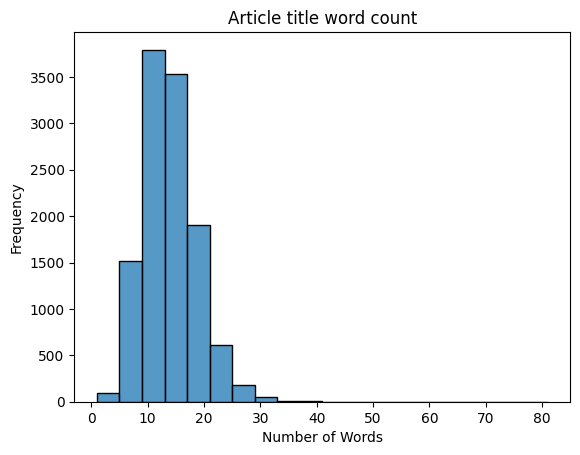

In [ ]:
title_txt = 'Article title word count'

plot_word_count_histogram(title_word_counts, title_txt)

#### 4.3.2 Article text word count

In [ ]:
text_word_counts = get_word_counts(pmc_arxiv_full_text_merged_plus_cleaned_article_titles['text'])

Summary statistics using the `describe()` function

In [ ]:
text_word_counts.describe()

count    11693.000000
mean      5441.827418
std       3336.680253
min          0.000000
25%       3522.000000
50%       4774.000000
75%       6564.000000
max      90399.000000
Name: text, dtype: float64

The mean number of words for an article is 5442 and minimum is zero, which means we have overlooked some rows with missing text even though no rows in the text column were showing up as having null values. The maximum is 90399.

We will identify and drop the rows which have missing text.

In [ ]:
# Filter the DataFrame to find rows where the word count is equal to 0
rows_with_word_count_of_0 = pmc_arxiv_full_text_merged_plus_cleaned_article_titles.text[text_word_counts == 0]
rows_with_word_count_of_0

1157                           \n
1367                         \n\n
1566                           \n
5805                         \n\n
7094                           \n
11389    \n\n\n\n\n\n\n\n\n\n\n\n
Name: text, dtype: object

Six articles have new line characters in the text column.

In [ ]:
df_new = pmc_arxiv_full_text_merged_plus_cleaned_article_titles.copy()

In [ ]:
# Get the word count of the article text
df_new['word_count'] = df_new['text'].str.split().apply(len)

# Find articles with 0 words
articles_with_zero_words = df_new[df_new['word_count'] == 0]

# Display the articles with 0 words
print("Articles with 0 words:")
print(articles_with_zero_words)

Articles with 0 words:
       article_id   published     revised  \
1157   PMC8713546  2021-12-24  2022-10-05   
1367   PMC9116066  2022-05-18  2022-07-16   
1566   PMC8809230  2022-02-02  2022-07-16   
5805   PMC7180666  2020-04-24  2022-07-16   
7094   PMC8548270  2021-10-21  2022-10-05   
11389  PMC9094125  2022-05-11  2022-07-16   

                                                   title  \
1157   Discovery of potential anti-SARS-CoV-2 drugs b...   
1367   Chinese Medicine Meets Conventional Medicine i...   
1566   A chitosan-mediated inhalable nanovaccine agai...   
5805       SARS-Cov-2 (human) and COVID-19: Primer 2020.   
7094   Natural products for infectious microbes and d...   
11389  Recent advances in metal-organic framework-bas...   

                                           title_cleaned  \
1157   Discovery of potential anti-SARS-CoV-2 drugs b...   
1367   Chinese Medicine Meets Conventional Medicine i...   
1566   A chitosan-mediated inhalable nanovaccine agai...   


In [ ]:
df_new_zero = df_new[df_new['text'].str.strip() == '']
df_new_zero

article_id   published     revised  \
1157   PMC8713546  2021-12-24  2022-10-05   
1367   PMC9116066  2022-05-18  2022-07-16   
1566   PMC8809230  2022-02-02  2022-07-16   
5805   PMC7180666  2020-04-24  2022-07-16   
7094   PMC8548270  2021-10-21  2022-10-05   
11389  PMC9094125  2022-05-11  2022-07-16   

                                                   title  \
1157   Discovery of potential anti-SARS-CoV-2 drugs b...   
1367   Chinese Medicine Meets Conventional Medicine i...   
1566   A chitosan-mediated inhalable nanovaccine agai...   
5805       SARS-Cov-2 (human) and COVID-19: Primer 2020.   
7094   Natural products for infectious microbes and d...   
11389  Recent advances in metal-organic framework-bas...   

                                           title_cleaned  \
1157   Discovery of potential anti-SARS-CoV-2 drugs b...   
1367   Chinese Medicine Meets Conventional Medicine i...   
1566   A chitosan-mediated inhalable nanovaccine agai...   
5805       SARS-Cov-2 (human) and COVID-19: Primer 2020.   
7094   Natural products for infectious microbes and d...   
11389  Recent advances in metal-organic framework-bas...   

                                       journal  \
1157              Science China. Life sciences   
1367   Chinese journal of integrative medicine   
1566                             Nano research   
5805                  Hepatology international   
7094              Science China. Life sciences   
11389                            Nano research   

                                                 authors  \
1157   Peng H, Ding C, Jiang L, Tang W, Liu Y, Zhao L...   
1367   Wang SS, Zeng X, Wang YL, Dongzhi Z, Zhao YF, ...   
1566      Zhuo SH, Wu JJ, Zhao L, Li WH, Zhao YF, Li YM.   
5805   Ramakrishna G, Kumar P, Aggarwal S, Islam M, S...   
7094   Luo L, Yang J, Wang C, Wu J, Li Y, Zhang X, Li...   
11389            Yang M, Zhang J, Wei Y, Zhang J, Tao C.   

                              doi  \
1157    10.1007/s11427-021-2031-7   
1367    10.1007/s11655-022-3573-0   
1566    10.1007/s12274-021-4012-9   
5805   10.1007/s12072-020-10049-7   
7094    10.1007/s11427-020-1959-5   
11389   10.1007/s12274-022-4302-x   

                                                 pdf_url  \
1157   https://europepmc.org/articles/PMC8713546?pdf=...   
1367   https://europepmc.org/articles/PMC9116066?pdf=...   
1566   https://europepmc.org/articles/PMC8809230?pdf=...   
5805   https://europepmc.org/articles/PMC7180666?pdf=...   
7094   https://europepmc.org/articles/PMC8548270?pdf=...   
11389  https://europepmc.org/articles/PMC9094125?pdf=...   

                           text  word_count  
1157                         \n           0  
1367                       \n\n           0  
1566                         \n           0  
5805                       \n\n           0  
7094                         \n           0  
11389  \n\n\n\n\n\n\n\n\n\n\n\n           0

We will drop the six rows from the DataFrame.

In [ ]:
# List of article_id values to drop
article_ids_to_drop = ['PMC8713546', 'PMC9116066', 'PMC8809230', 'PMC7180666', 'PMC8548270', 'PMC9094125']

# Get the index of rows with specified article_id values
rows_to_drop = df_new[df_new['article_id'].isin(article_ids_to_drop)].index

# Drop the specified rows
df_dropped = df_new.drop(rows_to_drop)

# Reset the index
df_dropped = df_dropped.reset_index(drop=True)

In [ ]:
pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated = df_dropped.copy()

In [ ]:
len(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated)

11687

In [ ]:
with open('2024-02-05_pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.pickle', 'wb') as f:
  pickle.dump(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated, f)

In [ ]:
text_word_counts_updated = get_word_counts(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated['text'])

Summary statistics of updated DataFrame using the `describe()` function

In [ ]:
text_word_counts_updated.describe()

count    11687.000000
mean      5444.621203
std       3335.256961
min         24.000000
25%       3523.000000
50%       4775.000000
75%       6564.000000
max      90399.000000
Name: text, dtype: float64

The minimum number of words is now 24. A very short article! Almost certainly not the full text of a research paper but we will leave it in the dataset. The maximum length of 90399 is another anomaly perhaps, or just a very long document, again we will leave it in the dataset.



Plot a histogram to show the word count distribution.

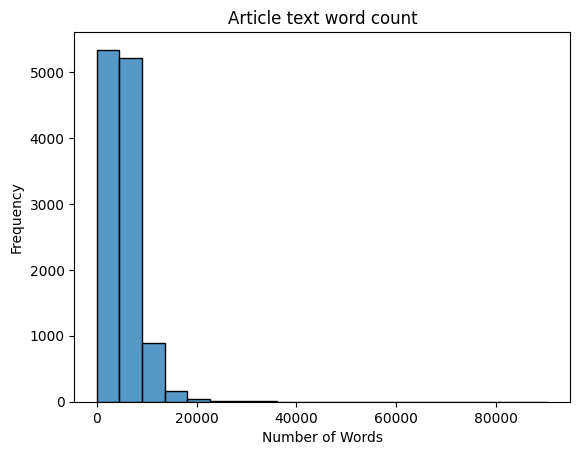

In [ ]:
title_txt = 'Article text word count'

plot_word_count_histogram(text_word_counts_updated, title_txt)

The histogram confirms that the mean word count is 5445 although it does not clearly show that there are now no rows with a count of zero.

The counts will not be 100% accurate as `split()` is a naive tokenisation method and does not cover any corner cases. Stopwords will also be included here.

#### 4.3.3 Article text sentence count

We will use spaCy's statistical [SentenceRecognizer](https://spacy.io/api/sentencerecognizer) which provides fast sentence segmentation using machine learning models. Its senter component is ~10x faster than the default  [DependencyParser](https://spacy.io/api/dependencyparser) which uses the full dependency parse to determine sentence boundaries, and more accurate than the rule-based [Sentencizer](https://spacy.io/api/sentencizer) which sets sentence boundaries using a customisable list of sentence-final punctuation.

For faster sentence segmentation, we will disable everything that's enabled by default and then enable senter. Since the senter component  is not found in the scispaCy en_core_sci_sm pipeline we will use the spaCy en_core_web_sm model.







In [ ]:
# Load the small English model and disable unused pipeline components
nlp = spacy.load("en_core_web_sm", disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer", "ner"])
# Enable senter pipeline component
nlp.enable_pipe("senter")

def get_sentence_count(doc):
    # Parse the document with spaCy
    doc = nlp(doc)

    # Return the number of sentences in the document
    return len(list(doc.sents))

In [ ]:
def apply_sentence_count(text):
    # Create a ProcessPoolExecutor
    with ProcessPoolExecutor() as executor:
        # Apply the get_sentence_count function to the text column
        sentence_counts = list(executor.map(get_sentence_count, text))

    return sentence_counts

In [ ]:
%%time
sentence_counts = apply_sentence_count(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.text)

CPU times: user 11 s, sys: 2.56 s, total: 13.6 s
Wall time: 7min 56s


In [ ]:
total_sents = sum(sentence_counts)
total_sents

2616346

In [ ]:
with open('2024-02-24_pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated_sent_counts.pickle', 'wb') as f:
  pickle.dump(sentence_counts, f)

In [ ]:
pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated['sent_count'] = sentence_counts

In [ ]:
pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.head(1)

article_id   published     revised  \
0  PMC9549161  2022-09-26  2022-10-14   

                                          title  \
0  Drug repositioning: A bibliometric analysis.   

                                  title_cleaned                    journal  \
0  Drug repositioning: A bibliometric analysis.  Frontiers in pharmacology   

                                             authors  \
0  Sun G, Dong D, Dong Z, Zhang Q, Fang H, Wang C...   

                         doi  \
0  10.3389/fphar.2022.974849   

                                             pdf_url  \
0  https://europepmc.org/articles/PMC9549161?pdf=...   

                                                text  word_count  sent_count  
0  Sir James Black, a winner of the 1988 Nobel Pr...        7309         253

In [ ]:
with open('2024-02-24_pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.pickle', 'wb') as f:
  pickle.dump(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated, f)

In [ ]:
pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11687 entries, 0 to 11686
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_id     11687 non-null  object
 1   published      11687 non-null  object
 2   revised        11687 non-null  object
 3   title          11687 non-null  object
 4   title_cleaned  11687 non-null  object
 5   journal        11426 non-null  object
 6   authors        11687 non-null  object
 7   doi            11450 non-null  object
 8   pdf_url        11687 non-null  object
 9   text           11687 non-null  object
 10  word_count     11687 non-null  int64 
 11  sent_count     11687 non-null  int64 
dtypes: int64(2), object(10)
memory usage: 1.1+ MB


In [ ]:
sentence_counts = pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.sent_count

Summary statistics using the `describe()` function

In [ ]:
sentence_counts.describe()

count    11687.000000
mean       223.868059
std        147.139082
min          1.000000
25%        138.000000
50%        194.000000
75%        271.000000
max       4071.000000
Name: sent_count, dtype: float64

The mean number of sentences for an article is 224, minimum is one sentence and maximum is 4071.

In [ ]:
rows_with_sent_count_of_1 = pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated[pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated['sent_count'] == 1]
rows_with_sent_count_of_1

article_id   published     revised  \
3241  PMC8223035  2021-06-24  2022-07-16   

                                                  title  \
3241  A Crystallographic Snapshot of SARS-CoV-2 Main...   

                                          title_cleaned  \
3241  A Crystallographic Snapshot of SARS-CoV-2 Main...   

                           journal  \
3241  Journal of molecular biology   

                                                authors  \
3241  Noske GD, Nakamura AM, Gawriljuk VO, Fernandes...   

                            doi  \
3241  10.1016/j.jmb.2021.167118   

                                                pdf_url  \
3241  https://europepmc.org/articles/PMC8223035?pdf=...   

                                                   text  word_count  \
3241  Severe acute respiratory syndrome coronavirus ...          24   

      sent_count  
3241           1

In [ ]:
pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.iloc[3241, 9]

'Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) is the causative agent of COVID-19, a highly infectious disease that rapidly spreads causing a global pandemic.'

For some reason we only have the first sentence of the article but we will keep it in the dataset.

In [ ]:
def plot_sentence_count_histogram(sentence_counts, title_txt):
    # Create a histogram
    sns.histplot(sentence_counts, kde=False, bins=20)

    # Add labels and title
    plt.xlabel('Number of Sentences')
    plt.ylabel('Frequency')
    plt.title(title_txt)

    # Show the plot
    plt.show()

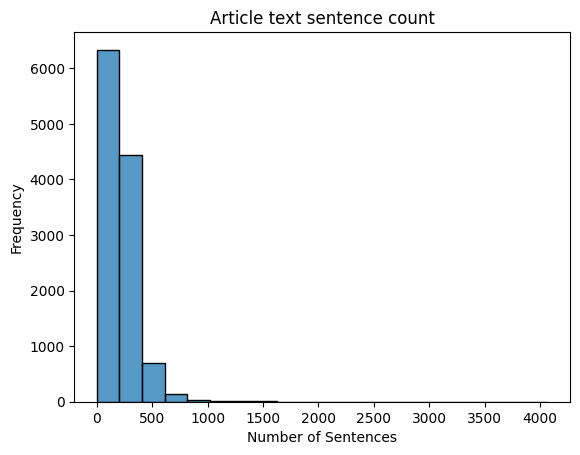

In [ ]:
title_txt = 'Article text sentence count'
plot_sentence_count_histogram(sentence_counts, title_txt)

### 4.4 Text complexity

The [Textstat](https://github.com/textstat/textstat) library will be used to calculate statistics from the article text to demonstrate how  to determine readability, complexity, and grade level.

Here we will implement the Flesch Reading Ease index for the first 100 articles.

| Flesch Reading Ease Score | Difficulty |
| --- | --- |
| 90-100 | Very Easy |
| 80-89 | Easy |
| 70-79 | Fairly Easy |
| 60-69 | Standard |
|50-59 | Fairly Difficult|
| 30-49 | Difficult |
| 0-29 | Very Confusing |





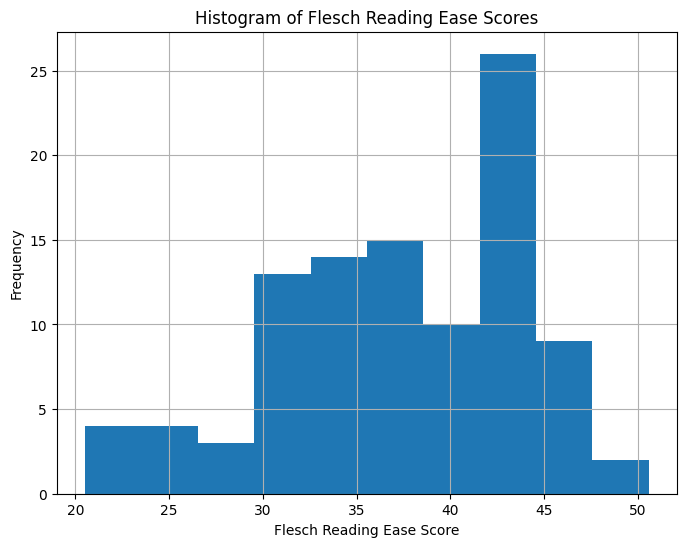

In [ ]:
reading_scores = pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated['text'][0:100].apply(lambda x: flesch_reading_ease(x))

# Set the figure size
plt.figure(figsize=(8, 6))

# Create the histogram
reading_scores.hist()

# Add labels and title
plt.xlabel('Flesch Reading Ease Score')
plt.ylabel('Frequency')
plt.title('Histogram of Flesch Reading Ease Scores')

# Show the plot
plt.show()

Scores range from Fairly Difficult to Very Confusing!

## 5. Word Analysis

We will analyse and customise spaCy's stopwords, add special cases and use regular expressions to extract domain specific n-grams.

### 5.1 Stopwords


Stopwords have little semantic meaning and are considered noise as they do not carry significant information about content or context.



Get a set of all stopwords from spaCy

In [ ]:
spacy_stopwords = stop_words.STOP_WORDS

In [ ]:
len(spacy_stopwords)

326

spaCy has a default list of 326 stopwords which are displayed below.

In [ ]:
spacy_stopwords

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

#### 5.1.1 Article title stopwords


We will define a function to return a dictionary of stopwords and counts which we can then visualise.

In [ ]:
# Load scispacy small biomedical model
nlp = spacy.load("en_core_sci_sm")

In [ ]:
# Display full pipeline components
nlp.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer', 'parser', 'ner']

In [ ]:
# Load model and disable unused components
nlp = spacy.load("en_core_sci_sm", disable=['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer', 'parser', 'ner'])

In [ ]:
nlp.pipe_names

[]

In [ ]:
def get_stopwords_and_counts(text):
    stop = set(word.lower() for word in nlp.Defaults.stop_words)
    corpus = []
    for doc in nlp.pipe(text):
        corpus.extend([token.text.lower() for token in doc if token.text.lower() in stop])
    dic = defaultdict(int)
    for word in corpus:
        dic[word] += 1
    return dic

In [ ]:
stopwords_titles = get_stopwords_and_counts(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.title_cleaned)

In [ ]:
stopwords_titles

defaultdict(int,
            {'a': 3180,
             'on': 1083,
             'and': 7096,
             'for': 3317,
             'as': 1108,
             'to': 1793,
             'of': 8743,
             'against': 1085,
             'the': 4337,
             'using': 610,
             'in': 4412,
             'two': 41,
             'by': 767,
             'an': 773,
             'towards': 89,
             'various': 24,
             'from': 900,
             'with': 1260,
             'used': 53,
             'other': 59,
             'more': 30,
             'than': 24,
             'through': 216,
             'its': 259,
             'be': 52,
             'at': 108,
             'beyond': 49,
             'into': 167,
             'some': 46,
             'forty': 1,
             'during': 116,
             'four': 8,
             'between': 169,
             'among': 59,
             "'s": 647,
             'what': 35,
             'about': 20,
             'their': 211,
    

In [ ]:
with open('2024-02-27_stopwords_titles.pickle', 'wb') as f:
  pickle.dump(stopwords_titles, f)

#### Plot article title stopwords

We will define a function to plot the top 20 stopwords in article titles.

In [ ]:
def plot_top_stopwords_barchart(stopwords_counts, title_txt):
    top = sorted(stopwords_counts.items(), key=lambda x: x[1], reverse=True)[:20]
    x, y = zip(*top)
    plt.figure(figsize=(15, 5))
    sns.barplot(x=list(x), y=list(y), palette='viridis')
    plt.xlabel('Stop Words')
    plt.ylabel('Frequency')
    plt.title(title_txt)
    plt.show()

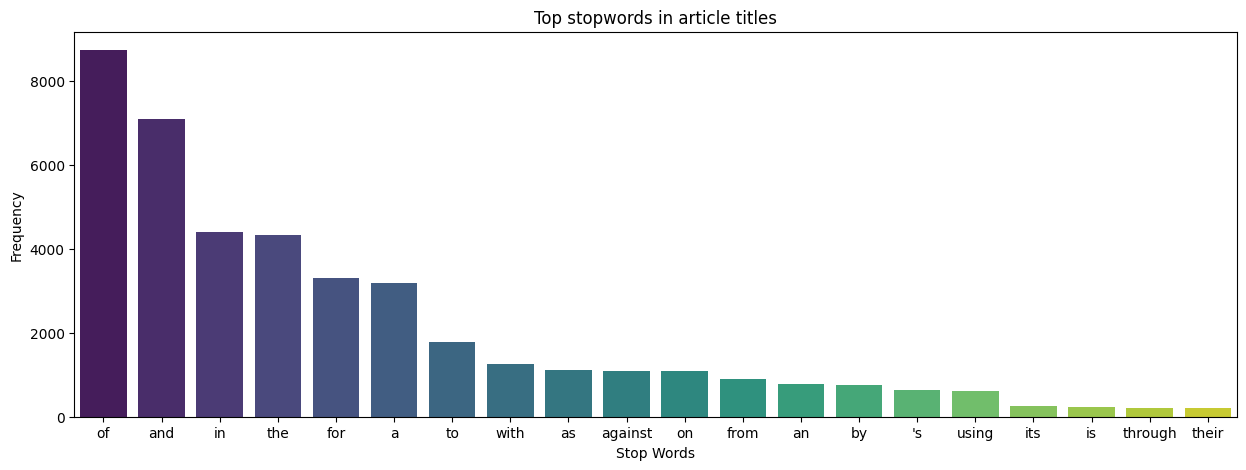

In [ ]:
title_txt = 'Top stopwords in article titles'

plot_top_stopwords_barchart(stopwords_titles, title_txt)

#### 5.1.2 Article text stopwords

We will use the same functions to extract stopwords and counts, and plot the top 20 stopwords for the text from the first 10 articles.

In [ ]:
stopwords_text = get_stopwords_and_counts(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.text)

In [ ]:
stopwords_text

defaultdict(int,
            {'a': 984642,
             'of': 2347159,
             'the': 3676687,
             'well': 54857,
             'before': 17360,
             'that': 503073,
             'would': 25596,
             'an': 220515,
             'in': 1525764,
             'and': 2124623,
             'to': 1325428,
             'using': 146962,
             'for': 703701,
             'are': 355588,
             'these': 168156,
             'but': 66306,
             'do': 13936,
             'not': 139645,
             'show': 19836,
             'has': 158881,
             'been': 152089,
             'by': 400092,
             'used': 148250,
             'them': 21778,
             'it': 167358,
             'should': 26823,
             'be': 289176,
             'out': 27553,
             'often': 13975,
             'also': 162907,
             'after': 61612,
             'were': 367588,
             'its': 88217,
             'which': 210917,
             'most': 6

In [ ]:
with open('2024-02-27_stopwords_text.pickle', 'wb') as f:
  pickle.dump(stopwords_text, f)

####  Plot article text stopwords

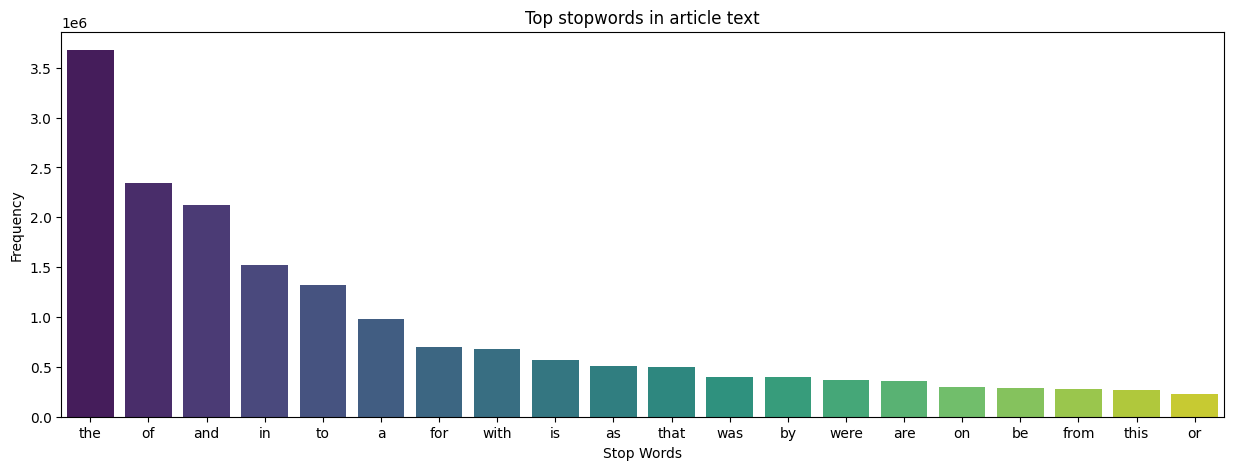

In [ ]:
title_txt = 'Top stopwords in article text'

plot_top_stopwords_barchart(stopwords_text, title_txt)

### 5.2 N-grams

An n-gram is a continuous sequence of *n* tokens in a document. We will consider unigrams, bigrams and trigrams, or single words, and two- and three-word noun phrases respectively, for article titles and text and plot the top 40.

#### 5.2.1 Article title top unigrams

In [ ]:
def get_unigrams_and_counts(text):
    stop = set(word.lower() for word in nlp.Defaults.stop_words)
    corpus = []
    for doc in nlp.pipe(text):
        corpus.extend([token.text.lower() for token in doc if token.text.lower() not in stop])
    dic = defaultdict(int)
    for word in corpus:
        dic[word] += 1
    return dic

In [ ]:
unigrams_titles = get_unigrams_and_counts(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.title_cleaned)

In [ ]:
unigrams_titles

defaultdict(int,
            {'drug': 1418,
             'repositioning': 107,
             ':': 3670,
             'bibliometric': 25,
             'analysis': 509,
             '.': 10949,
             'review': 532,
             'computer-aided': 20,
             'chemogenomics': 1,
             'rational': 36,
             'covid-19': 2542,
             'discovery': 543,
             'repurposing': 631,
             'molnupiravir': 15,
             'new': 337,
             'opportunity': 14,
             'treat': 65,
             'scope': 6,
             'repurposed': 96,
             'drugs': 628,
             'potential': 1190,
             'targets': 281,
             'latest': 7,
             'variants': 111,
             'sars-cov-2': 2653,
             'gene': 114,
             'co-expression': 6,
             'module': 4,
             'preservation': 2,
             'acute': 141,
             'respiratory': 177,
             'distress': 21,
             'syndrome': 152,
    

#### Plot article title top unigrams

In [ ]:
def plot_top_ngrams_barchart(word_counts, title_txt):
    top = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:40]
    x, y = zip(*top)
    plt.figure(figsize=(20, 10))
    sns.barplot(x=list(y), y=list(x), palette='viridis')
    plt.xlabel('Top Words')
    plt.ylabel('Frequency')
    plt.title(title_txt)
    plt.show()

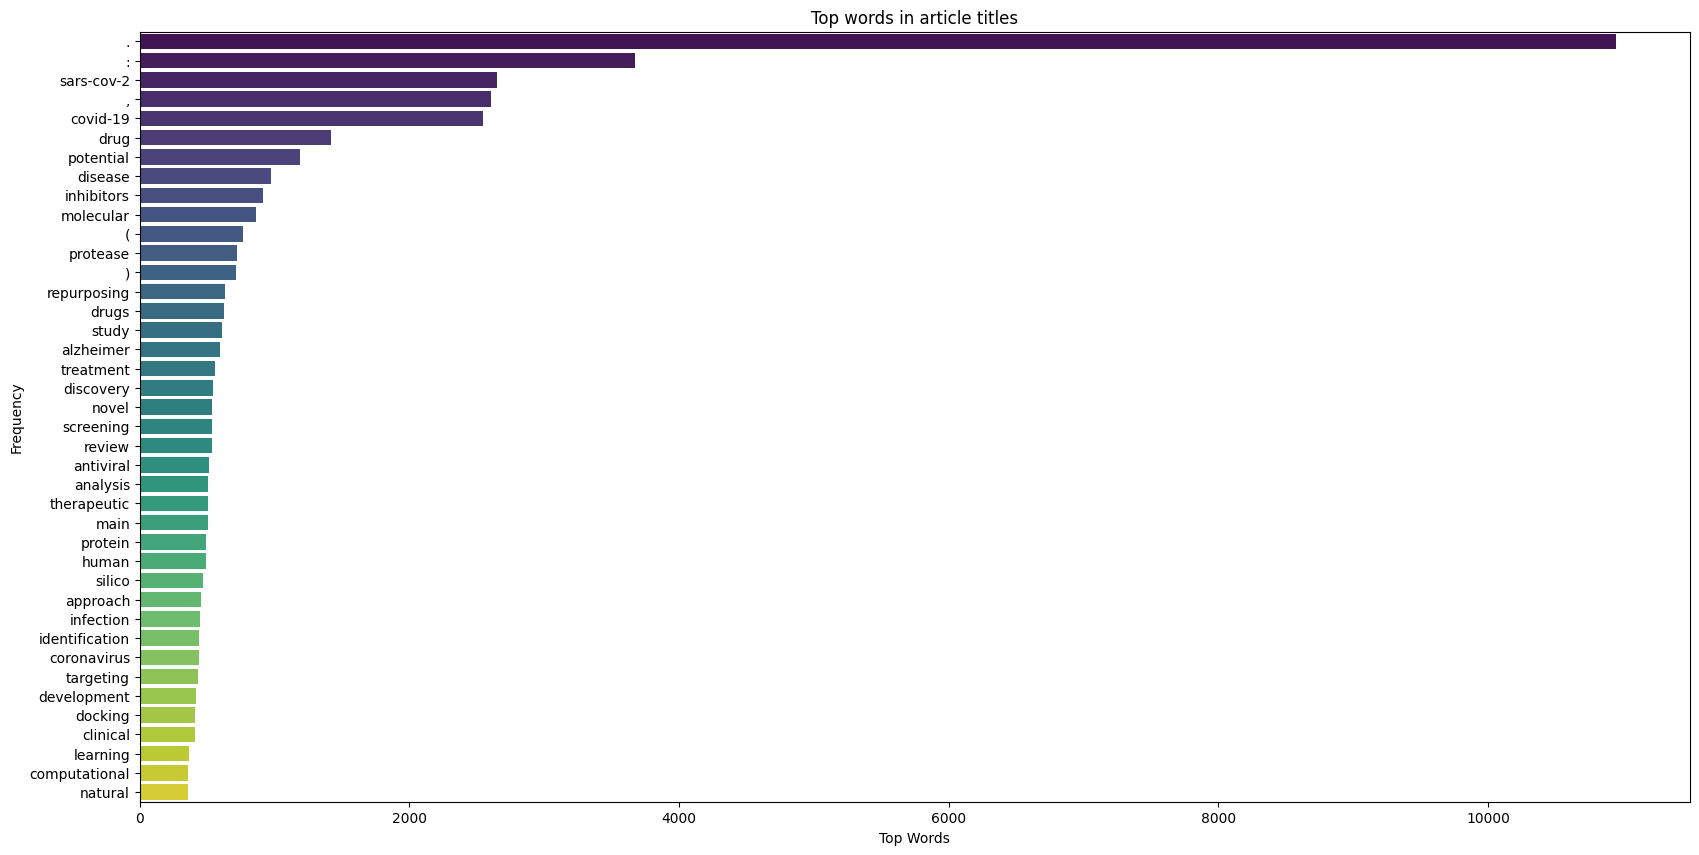

In [ ]:
title_txt = 'Top words in article titles'

plot_top_ngrams_barchart(unigrams_titles, title_txt)

We can see that punctuation is counted as tokens so we will amend the function to include a regex pattern to match only alpha characters, digits and hyphenated words. The token '*silico*' also appears as a unigram instead of as the compound '*in silico*' as 'in' is a stopword.

#### Add custom stopwords

Before further processing, we will add *et al* to custom stopwords as it appears frequently.

In [ ]:
# Load the small scispaCy model again and disable unused pipeline components
nlp = spacy.load("en_core_sci_sm", disable=['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer', 'parser', 'ner'])

In [ ]:
stop = set(word.lower() for word in nlp.Defaults.stop_words)
custom_stop_words = ["et", "al", "al."]
for item in custom_stop_words:
    stop.add(item)
    nlp.vocab[item].is_stop = True

#### Add special cases

As we have terms specific to the biomedical domain (e.g. *in silico*) we will add [special case tokenisation rules](https://spacy.io/usage/linguistic-features#special-cases) before filtering out stopwords or words that do not match the custom tokenisation rules.

The `Tokenizer.add_special_case` method is used to add custom tokeniser exceptions to the language data. The `ORTH` attribute is the exact verbatim of a token, e.g. "in vitro".


In [ ]:
def get_unigrams_and_counts(text):
    special_cases = [
        {ORTH: "in vitro"},
        {ORTH: "in silico"},
        {ORTH: "in vivo"}
    ]

    # Add each special case to the tokenizer
    for special_case in special_cases:
        nlp.tokenizer.add_special_case(special_case[ORTH], [special_case])

    # Regular expression pattern to match letters, digits, and hyphens
    pattern = re.compile(r'[A-Za-zα-ωΑ-Ω][A-Za-z0-9\-α-ωΑ-Ω]*')

    corpus = []
    for doc in nlp.pipe(text):
        # Filter out tokens that are stopwords or do not match the pattern
        for token in doc:
            # Check if the token is a special case
            if any(token.text.lower() == special_case[ORTH].lower() for special_case in special_cases):
                corpus.append(token.text.lower())
            # Check if the token is not a stopword and matches the pattern
            elif token.text.lower() not in stop and pattern.match(token.text):
                 corpus.append(token.text.lower())

    dic = defaultdict(int)
    for word in corpus:
        dic[word] += 1
    return dic

In [ ]:
unigrams_titles = get_unigrams_and_counts(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.title_cleaned)

In [ ]:
with open('2024-03-01_unigrams_titles.pickle', 'wb') as f:
  pickle.dump(unigrams_titles, f)

In [ ]:
len(unigrams_titles)

16351

In [ ]:
value = unigrams_titles.get('in silico')

In [ ]:
print(value)

174


In [ ]:
value = unigrams_titles.get('in-silico')

In [ ]:
print(value)

70


In [ ]:
value = unigrams_titles.get('silico')

In [ ]:
print(value)

292


In [ ]:
unigrams_titles

defaultdict(int,
            {'drug': 1418,
             'repositioning': 107,
             'bibliometric': 25,
             'analysis': 509,
             'review': 532,
             'computer-aided': 20,
             'chemogenomics': 1,
             'rational': 36,
             'covid-19': 2542,
             'discovery': 543,
             'repurposing': 631,
             'molnupiravir': 15,
             'new': 337,
             'opportunity': 14,
             'treat': 65,
             'scope': 6,
             'repurposed': 96,
             'drugs': 628,
             'potential': 1190,
             'targets': 281,
             'latest': 7,
             'variants': 111,
             'sars-cov-2': 2653,
             'gene': 114,
             'co-expression': 6,
             'module': 4,
             'preservation': 2,
             'acute': 141,
             'respiratory': 177,
             'distress': 21,
             'syndrome': 152,
             'ards': 8,
             'systemic': 33,


#### Plot article title top unigrams after adding custom stopwords and special cases

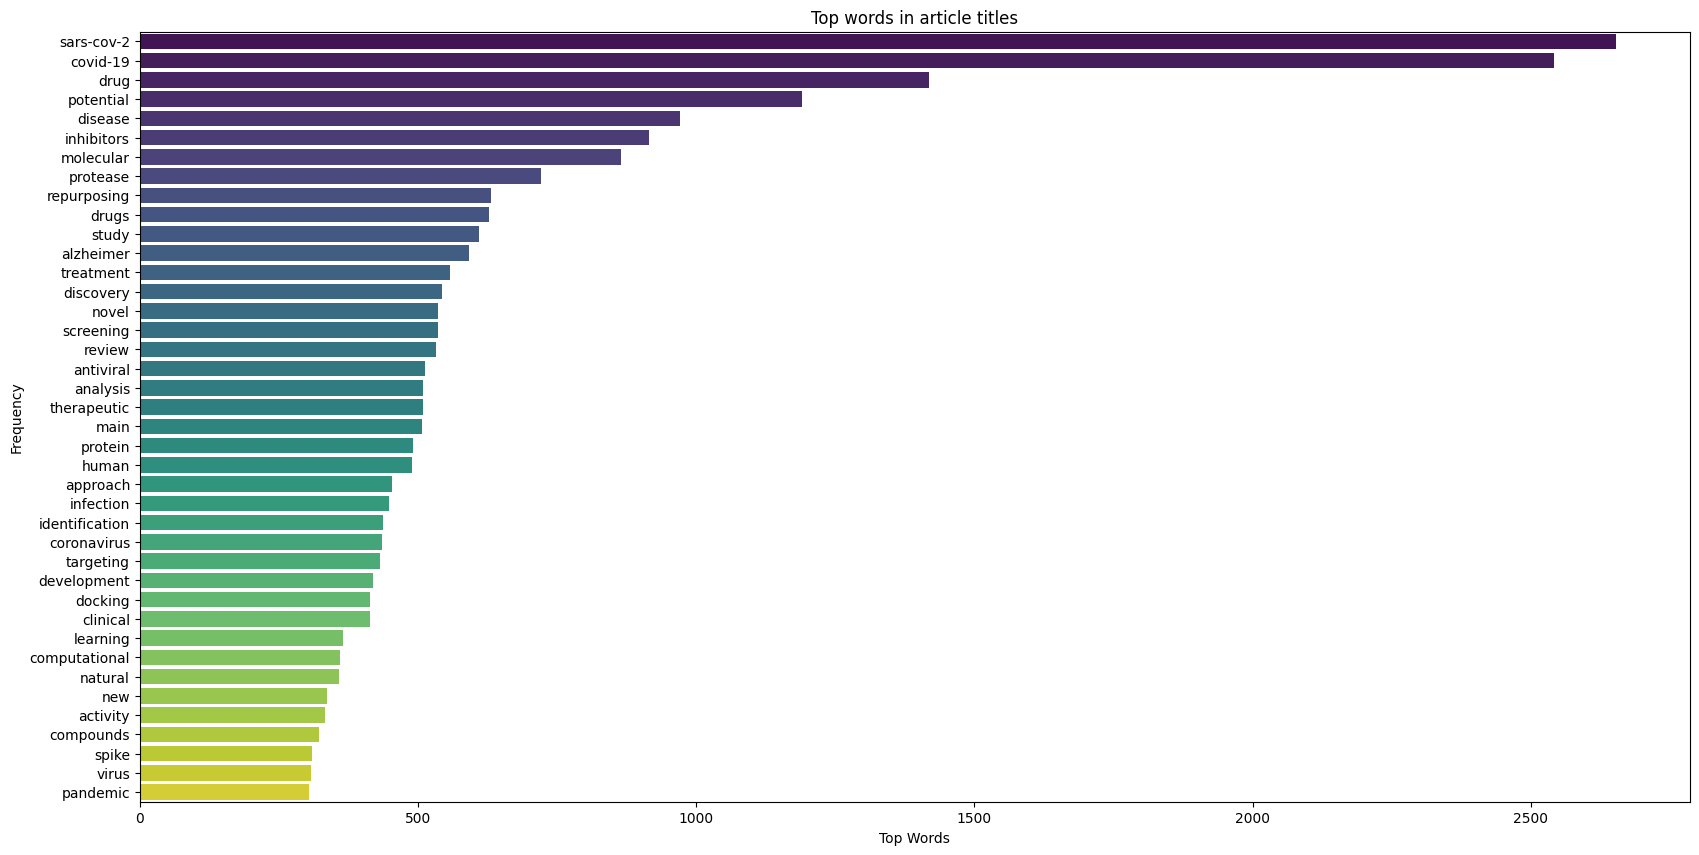

In [ ]:
title_txt = 'Top words in article titles'

plot_top_ngrams_barchart(unigrams_titles, title_txt)

Punctuation and *silico* no longer appear.

#### 5.2.2 Article text top unigrams

In [ ]:
unigrams_text = get_unigrams_and_counts(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.text)

In [ ]:
with open('2024-03-01_unigrams_text.pickle', 'wb') as f:
  pickle.dump(unigrams_text, f)

In [ ]:
len(unigrams_text)

713678

In [ ]:
value = unigrams_text.get('in silico')

In [ ]:
print(value)

7966


In [ ]:
value = unigrams_text.get('in-silico')

In [ ]:
print(value)

942


In [ ]:
value = unigrams_text.get('silico')

In [ ]:
print(value)

912


In [ ]:
unigrams_text

defaultdict(int,
            {'sir': 374,
             'james': 160,
             'black': 2536,
             'winner': 69,
             'nobel': 255,
             'prize': 249,
             'clearly': 4445,
             'recognized': 4758,
             'century': 1420,
             'drug': 133849,
             'repurposing': 13649,
             'strategies': 13247,
             'occupy': 679,
             'important': 41538,
             'place': 4004,
             'future': 17673,
             'new': 51832,
             'discovery': 27367,
             'ted': 29,
             't.': 2636,
             'ashburn': 28,
             'summarized': 4660,
             'previous': 20004,
             'research': 51103,
             'developed': 30480,
             'general': 12801,
             'approach': 34027,
             'development': 54508,
             'retrospectively': 213,
             'looking': 1249,
             'indications': 2590,
             'approved': 21670,
             '

#### Plot article text top unigrams

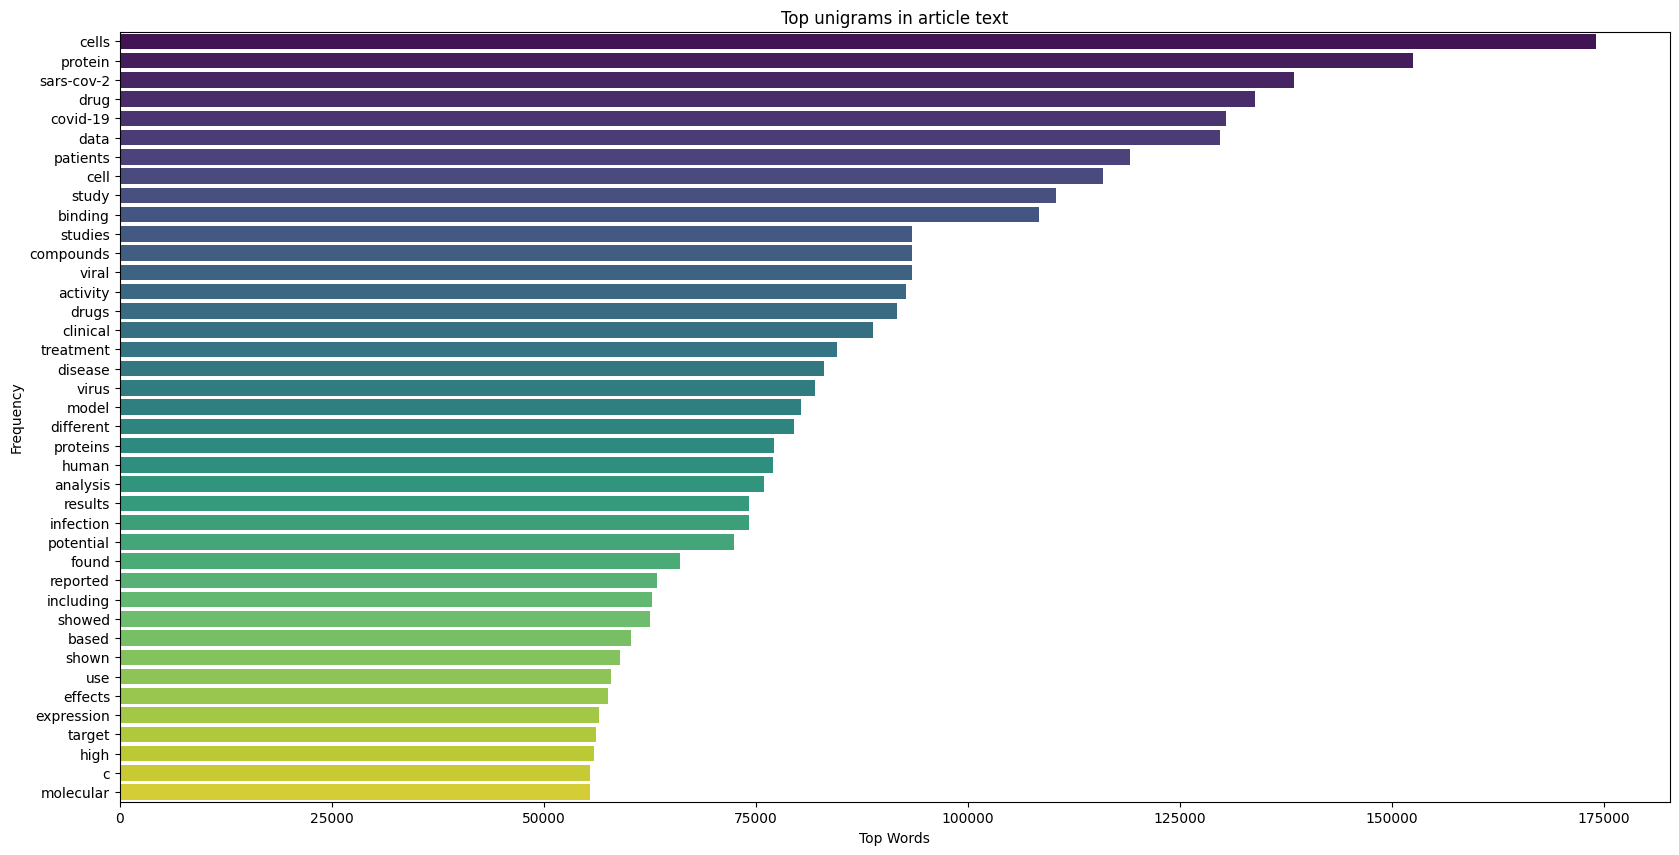

In [ ]:
title_txt = 'Top unigrams in article text'

plot_top_ngrams_barchart(unigrams_text, title_txt)

#### Define functions for stopwords and special cases

In [ ]:
# Load model and disable unused components
nlp = spacy.load("en_core_sci_sm", disable=['lemmatizer', 'parser', 'ner'])

We will refactor the code for stopwords and special cases to respect the separation of concerns design principle.

In [ ]:
def preprocess_stop_words():
    stop = set(word.lower() for word in nlp.Defaults.stop_words)
    custom_stop_words = ["et", "al", "al."]
    for item in custom_stop_words:
        stop.add(item)
        nlp.vocab[item].is_stop = True
    return stop

def add_special_cases():
    special_cases = [
        {ORTH: "in vitro"},
        {ORTH: "in silico"},
        {ORTH: "in vivo"}
    ]
    for special_case in special_cases:
        nlp.tokenizer.add_special_case(special_case[ORTH], [special_case])

Using the spaCy tokeniser's [`explain()`](https://spacy.io/api/tokenizer#explain) method we can access information about which tokeniser rule or pattern was matched for each token.

In [ ]:
tok_exp = nlp.tokenizer.explain("in silico")
tok_exp

[('TOKEN', 'in'), ('TOKEN', 'silico')]

By default the term is treated as separate tokens, or unigrams.

In [ ]:
add_special_cases()

tok_exp = nlp.tokenizer.explain("in silico")
tok_exp

[('SPECIAL-1', 'in silico')]

After adding the term as a special case it is recognised as such and appears correctly as a unigram.

#### 5.2.3 Article title top bigrams

The pipeline needs to include a morphologiser or tagger+attribute_ruler in order to use `Matcher` or `PhraseMatcher` with the attribute `POS` so we will retain the `'tok2vec', 'tagger', 'attribute_ruler'` components.





We will use spaCy's `Matcher()` class to create a rules-based pattern matcher to find two-word noun phrases.

After defining the bigram patterns with the following attributes and values, `[{"POS": "NOUN"}, {"POS": "NOUN"}]`, we will use the `.add` method to add the patterns into the Matcher.

This method takes two arguments:

1.   the label we want to assign to the matched token, `"BIGRAM"`
2.   the patterns themselves, `[bigram_pattern]`

In [ ]:
def get_bigrams_and_counts(text):
    stop = preprocess_stop_words()
    add_special_cases()

    # Initialise the Matcher
    matcher = Matcher(nlp.vocab)

    # Define the bigram pattern
    bigram_pattern = [{"POS": "NOUN"}, {"POS": "NOUN"}]
    matcher.add("BIGRAM", [bigram_pattern])

    # Regular expression pattern to match letters, digits, and hyphens
    pattern = re.compile(r'[A-Za-zα-ωΑ-Ω][A-Za-z0-9\-α-ωΑ-Ω]*')

    corpus = []

    # Process each document in the text
    for doc in nlp.pipe(text, batch_size=20):
        matches = matcher(doc)
        for _, start, end in matches:
            bigram_tokens = [token.text.lower() for token in doc[start:end] if token.text.lower() not in stop]
            bigram = " ".join(bigram_tokens)
            if pattern.match(bigram):
                corpus.append(bigram)

    bigram_counts = defaultdict(int)
    for bigram in corpus:
        bigram_counts[bigram] += 1

    return bigram_counts

In [ ]:
bigrams_titles = get_bigrams_and_counts(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.title_cleaned)

In [ ]:
with open('2024-03-01_bigrams_titles.pickle', 'wb') as f:
  pickle.dump(bigrams_titles, f)

In [ ]:
len(bigrams_titles)

7393

In [ ]:
bigrams_titles

defaultdict(int,
            {'covid-19 drug': 44,
             'drug discovery': 148,
             'drug repurposing': 161,
             'gene co-expression': 4,
             'distress syndrome': 17,
             'response syndrome': 2,
             'drugs cetilistat': 2,
             'rna polymerase': 97,
             'in silico perspective': 8,
             'nsp12 sars-cov-2': 1,
             'drug repositioning': 15,
             'repositioning strategies': 1,
             'sars-cov-2 nsp13': 7,
             'nsp13 helicase': 8,
             'silico drug': 14,
             'covid-19 treatment': 79,
             'silico study': 20,
             'interaction prediction': 10,
             'protease potential': 1,
             'machine learning': 103,
             'learning templates': 1,
             'weight regularization': 1,
             'regularization matrix': 1,
             'matrix factorization': 5,
             'network approaches': 1,
             'exploration platform': 1,


#### Plot article title top bigrams

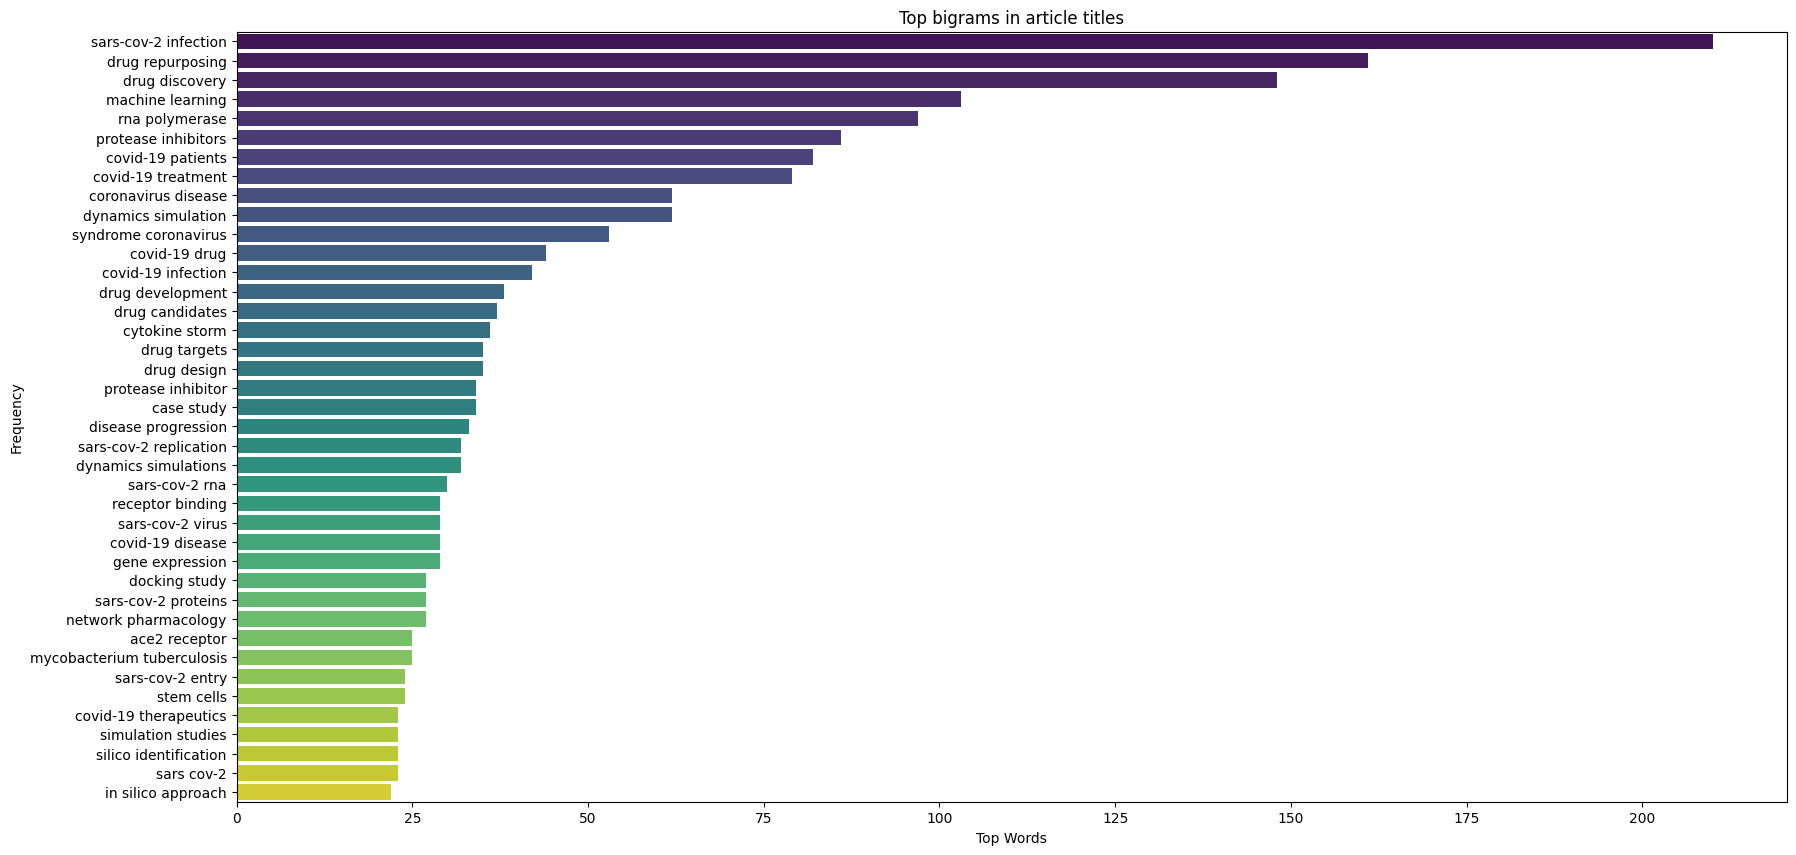

In [ ]:
title_txt = 'Top bigrams in article titles'

plot_top_ngrams_barchart(bigrams_titles, title_txt)

#### 5.2.4 Article text top bigrams

In [ ]:
bigrams_text = get_bigrams_and_counts(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.text)
with open('2024-03-01_bigrams_text.pickle', 'wb') as f:
  pickle.dump(bigrams_text, f)

In [ ]:
len(bigrams_text)

936425

In [ ]:
bigrams_text

defaultdict(int,
            {'drug repurposing': 5668,
             'repurposing strategies': 154,
             'drug discovery': 13817,
             'drug development': 6594,
             'drug repositioning': 1761,
             'drug rediscovery': 8,
             'drug retasking': 7,
             'research study': 175,
             'discovery process': 919,
             'development stage': 73,
             'risk –': 30,
             'venture capital': 49,
             'capital firms': 4,
             'erectile dysfunction': 90,
             'success stories': 75,
             'biology approaches': 140,
             'drug candidates': 4603,
             'systems biology': 595,
             'precision medicine': 1087,
             'computer methods': 18,
             'repositioning process': 12,
             'repurposing process': 45,
             'screening steps': 13,
             'database tools': 2,
             'research results': 173,
             'staggering number': 6,
      

#### Plot article text top bigrams

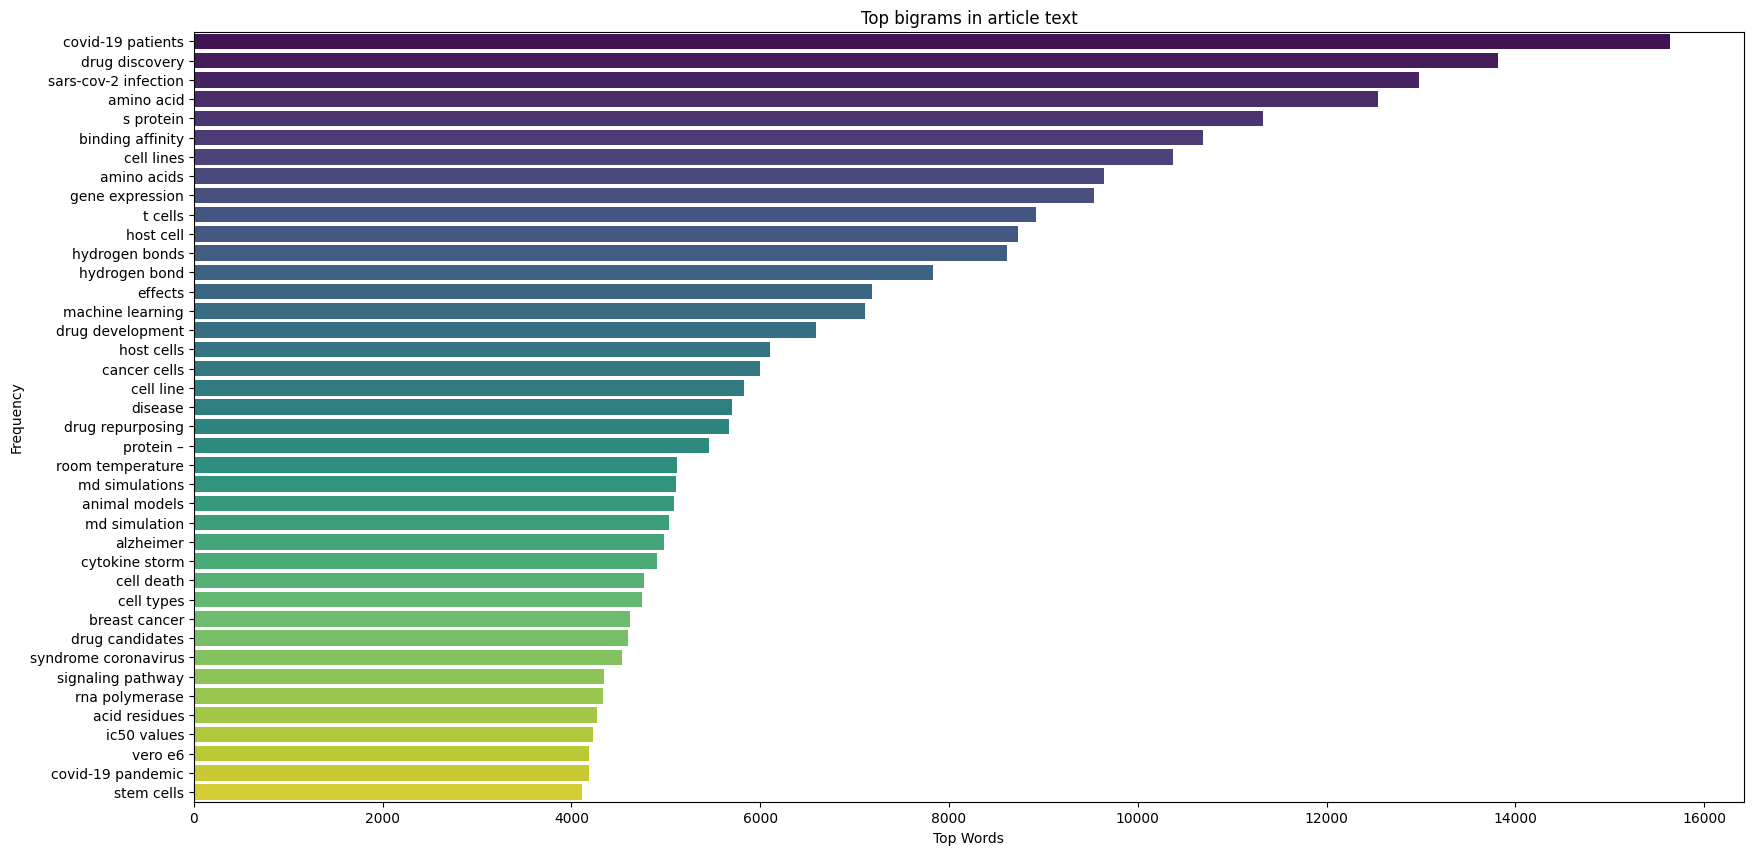

In [ ]:
title_txt = 'Top bigrams in article text'

plot_top_ngrams_barchart(bigrams_text, title_txt)

#### 5.2.5 Article title top trigrams

In [ ]:
def get_trigrams_and_counts(text):
    stop = preprocess_stop_words()
    add_special_cases()

    # Initialise the Matcher
    matcher = Matcher(nlp.vocab)

    # Define the bigram pattern
    trigram_pattern = [{"POS": "NOUN"}, {"POS": "NOUN"}, {"POS": "NOUN"}]
    matcher.add("TRIGRAM", [trigram_pattern])

    # Regular expression pattern to match letters, digits, and hyphens
    pattern = re.compile(r'[A-Za-zα-ωΑ-Ω][A-Za-z0-9\-α-ωΑ-Ω]*')

    corpus = []

    # Process each document in the text
    for doc in nlp.pipe(text, batch_size=20):
        matches = matcher(doc)
        for _, start, end in matches:
            trigram_tokens = [token.text.lower() for token in doc[start:end] if token.text.lower() not in stop]
            trigram = " ".join(trigram_tokens)
            if pattern.match(trigram):
                corpus.append(trigram)

    trigram_counts = defaultdict(int)
    for trigram in corpus:
        trigram_counts[trigram] += 1

    return trigram_counts

In [ ]:
trigrams_titles = get_trigrams_and_counts(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.title_cleaned)

In [ ]:
with open('2024-03-01_trigrams_titles.pickle', 'wb') as f:
  pickle.dump(trigrams_titles, f)

In [ ]:
len(trigrams_titles)

2106

In [ ]:
trigrams_titles

defaultdict(int,
            {'covid-19 drug discovery': 16,
             'drug repositioning strategies': 1,
             'sars-cov-2 nsp13 helicase': 4,
             'silico drug repurposing': 5,
             'machine learning templates': 1,
             'weight regularization matrix': 1,
             'regularization matrix factorization': 1,
             'kernel similarity bilinear': 1,
             'similarity bilinear matrix': 1,
             'bilinear matrix factorization': 1,
             'polyprotein processing inhibitor': 1,
             'sars-cov-2 rna-dependent rna': 7,
             'rna-dependent rna polymerase': 10,
             'covid-19 therapeutics search': 1,
             'drug repositioning algorithm': 1,
             'anticancer drug 5-fu': 1,
             'drug repurposing strategy': 7,
             'monkeypox infection prevention': 1,
             'deciphering covid-19 host': 1,
             'drug repurposing approach': 13,
             'rna binding proteins': 1,
 

#### Plot article title top trigrams

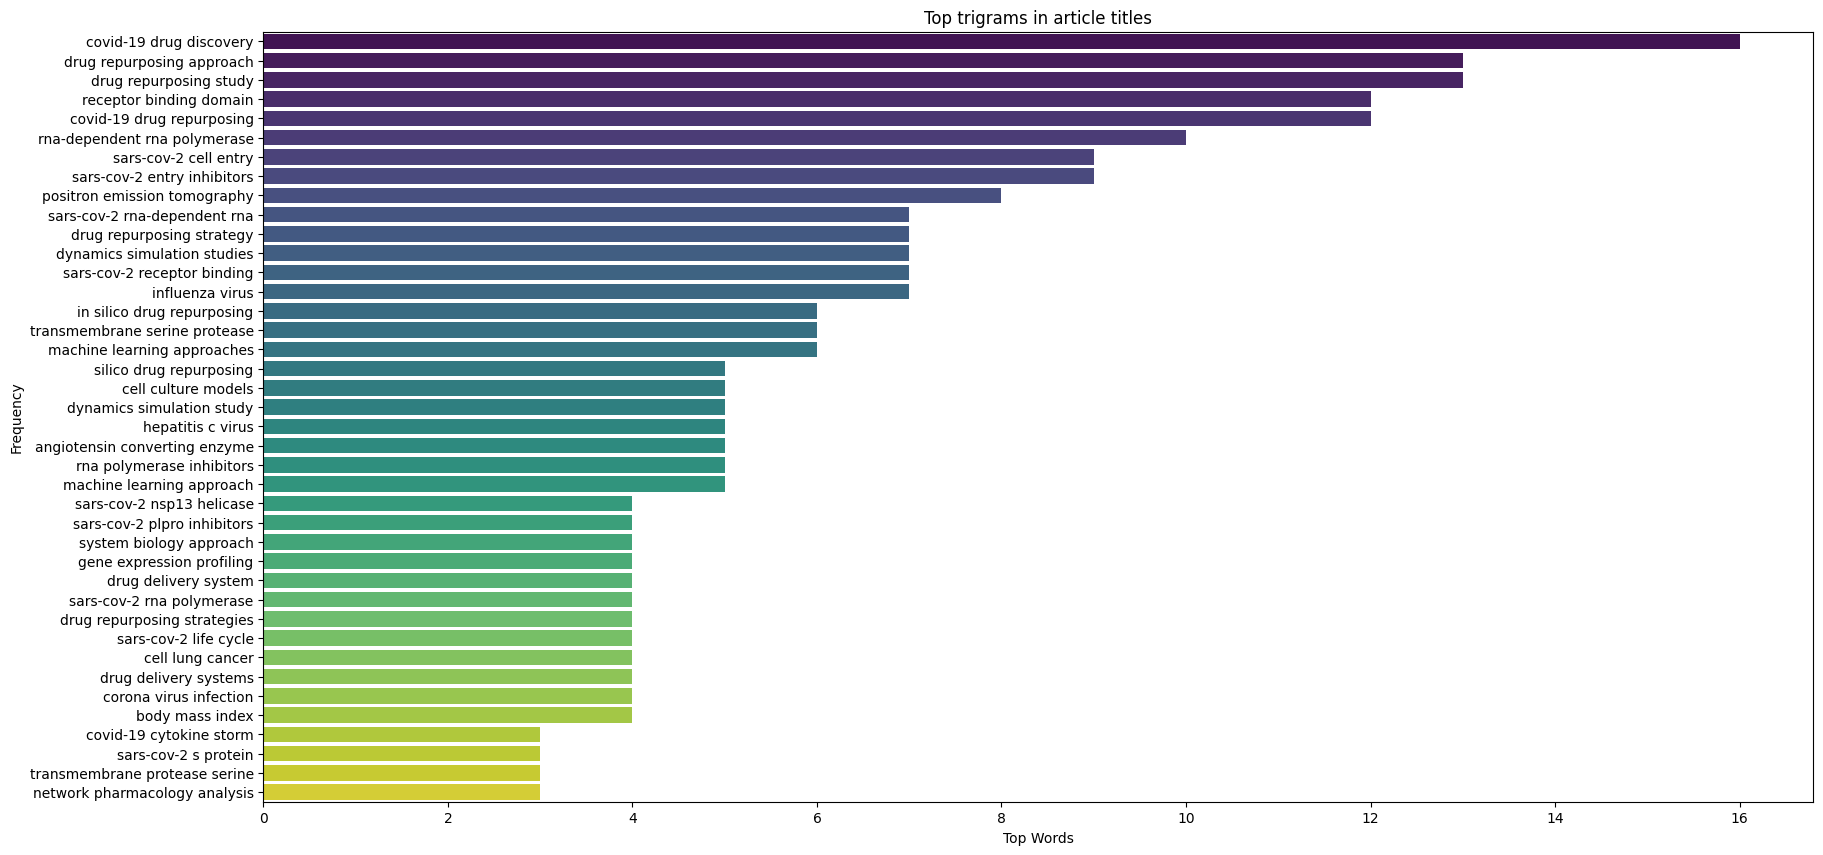

In [ ]:
title_txt = 'Top trigrams in article titles'

plot_top_ngrams_barchart(trigrams_titles, title_txt)

#### 5.2.6 Article text top trigrams

In [ ]:
trigrams_text = get_trigrams_and_counts(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.text)

with open('2024-03-01_trigrams_text.pickle', 'wb') as f:
  pickle.dump(trigrams_text, f)

In [ ]:
len(trigrams_text)

370909

In [ ]:
trigrams_text

defaultdict(int,
            {'drug repurposing strategies': 130,
             'risk – reward': 5,
             'venture capital firms': 4,
             'drug repositioning process': 10,
             'drug repurposing process': 28,
             'drug repurposing literature': 1,
             'drug – disease': 332,
             'drug repurposing research': 35,
             'drug repositioning publications': 2,
             'information data service': 1,
             'data service platform': 1,
             'citation indexes sci-e': 1,
             'formula “ drug': 1,
             'publication time parameters': 1,
             'drug repurposing definitions': 1,
             'data analysis efficiency': 1,
             'data cleaning tool': 1,
             'author': 1,
             'search formula conditions': 1,
             'study publication date': 1,
             'drug repositioning research': 27,
             'word “ researcher': 1,
             'dda analysis software': 1,
           

#### Plot article text top trigrams

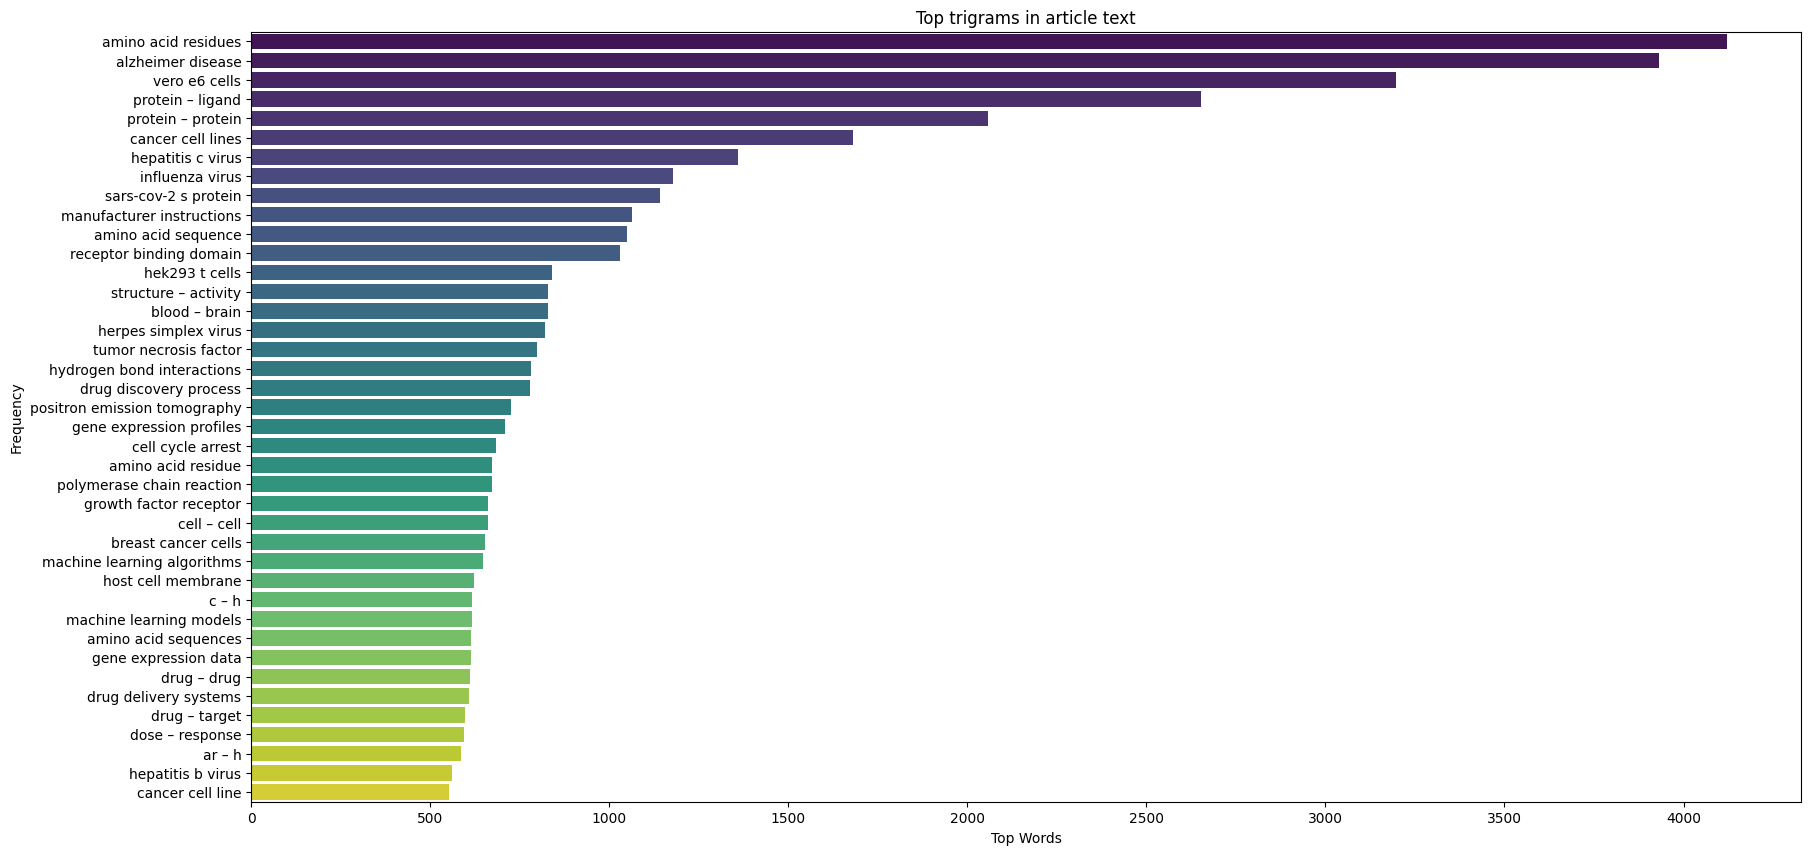

In [ ]:
title_txt = 'Top trigrams in article text'

plot_top_ngrams_barchart(trigrams_text, title_txt)

### 5.3 Wordclouds


We will plot wordclouds for the top 100 words in article titles and text for unigrams, bigrams and trigrams.

In [ ]:
def plot_ngrams_wordcloud(dic, title_txt):
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=600, max_words=100, background_color='white').generate_from_frequencies(dic)

    # Plot the word cloud
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title_txt)
    plt.show()


#### 5.3.1 Article title unigram wordcloud

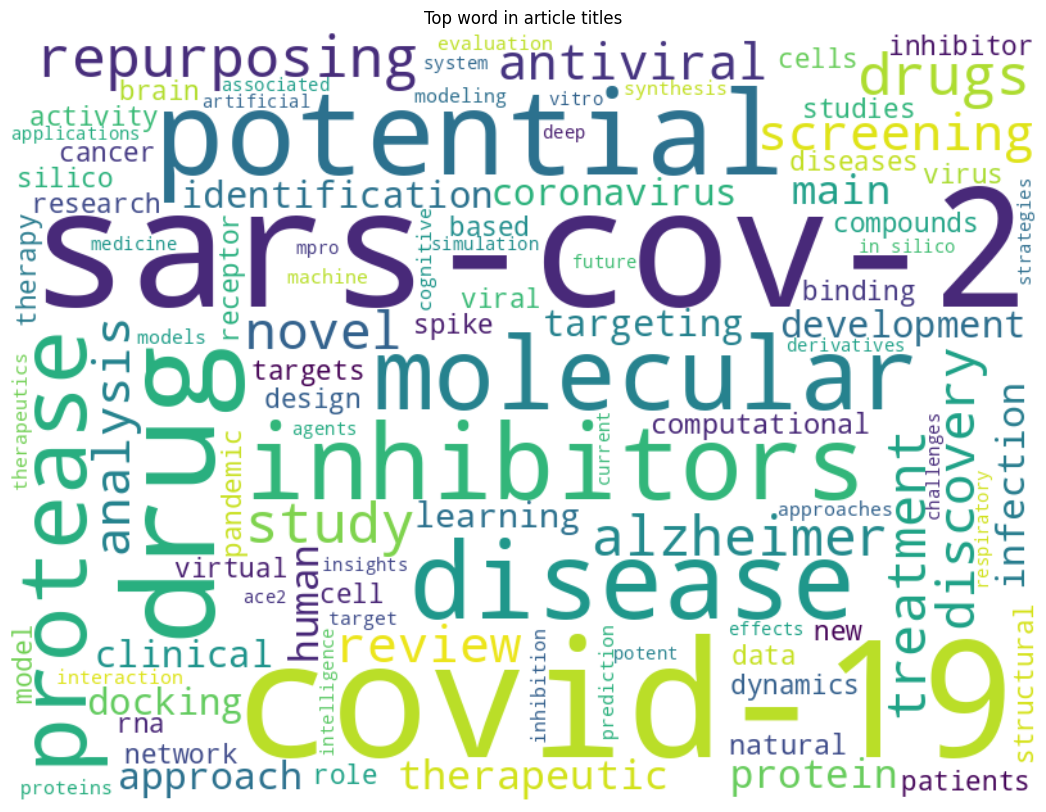

In [ ]:
title_txt = 'Top word in article titles'

plot_ngrams_wordcloud(unigrams_titles, title_txt)

#### 5.3.2 Article text unigram wordcloud

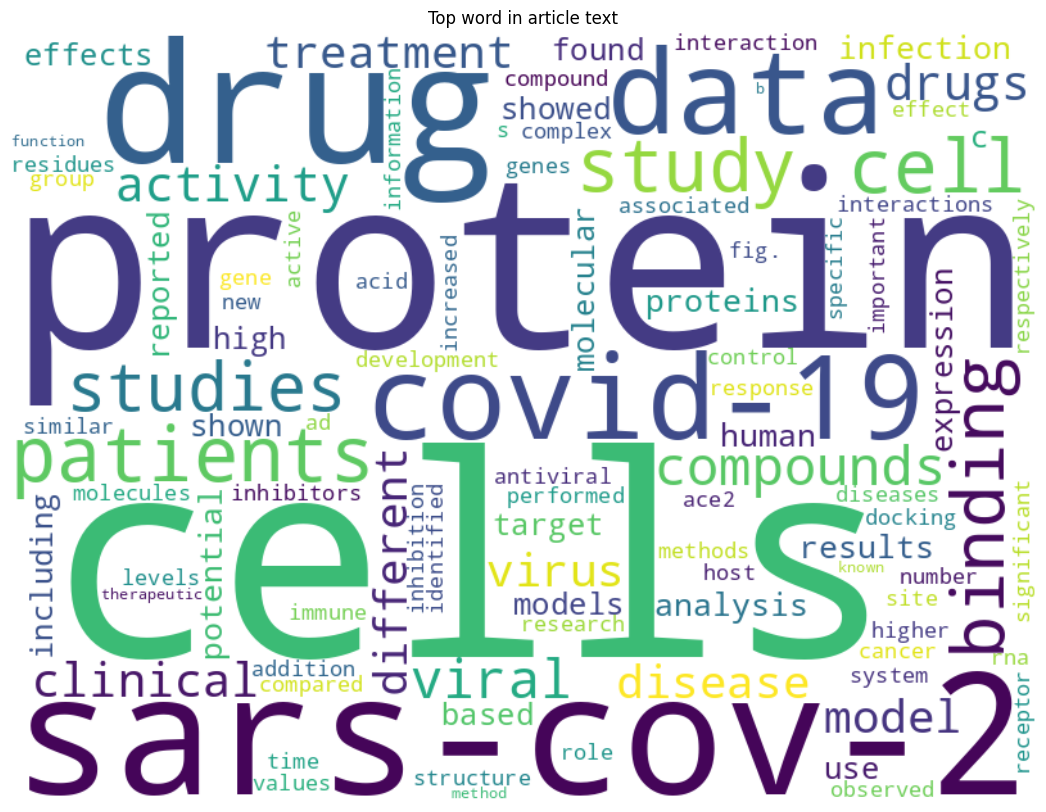

In [ ]:
title_txt = 'Top word in article text'

plot_ngrams_wordcloud(unigrams_text, title_txt)

#### 5.3.3 Article title bigram wordcloud

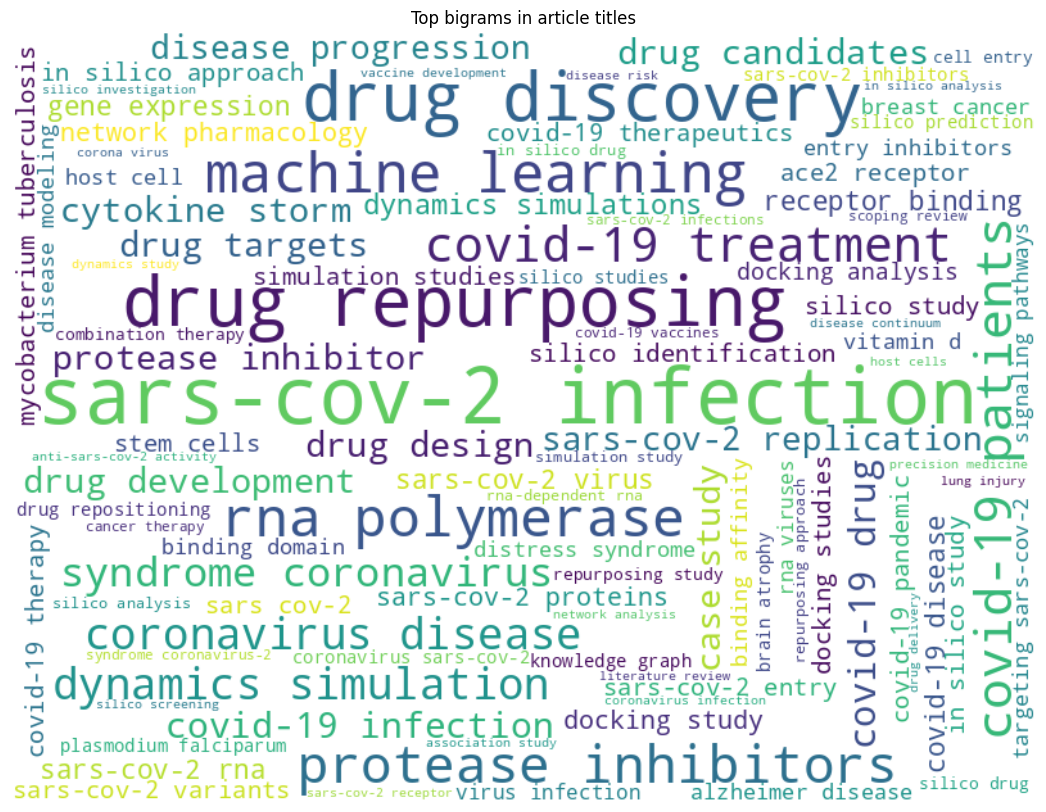

In [ ]:
title_txt = 'Top bigrams in article titles'

plot_ngrams_wordcloud(bigrams_titles, title_txt)

#### 5.3.4 Article text bigram wordcloud

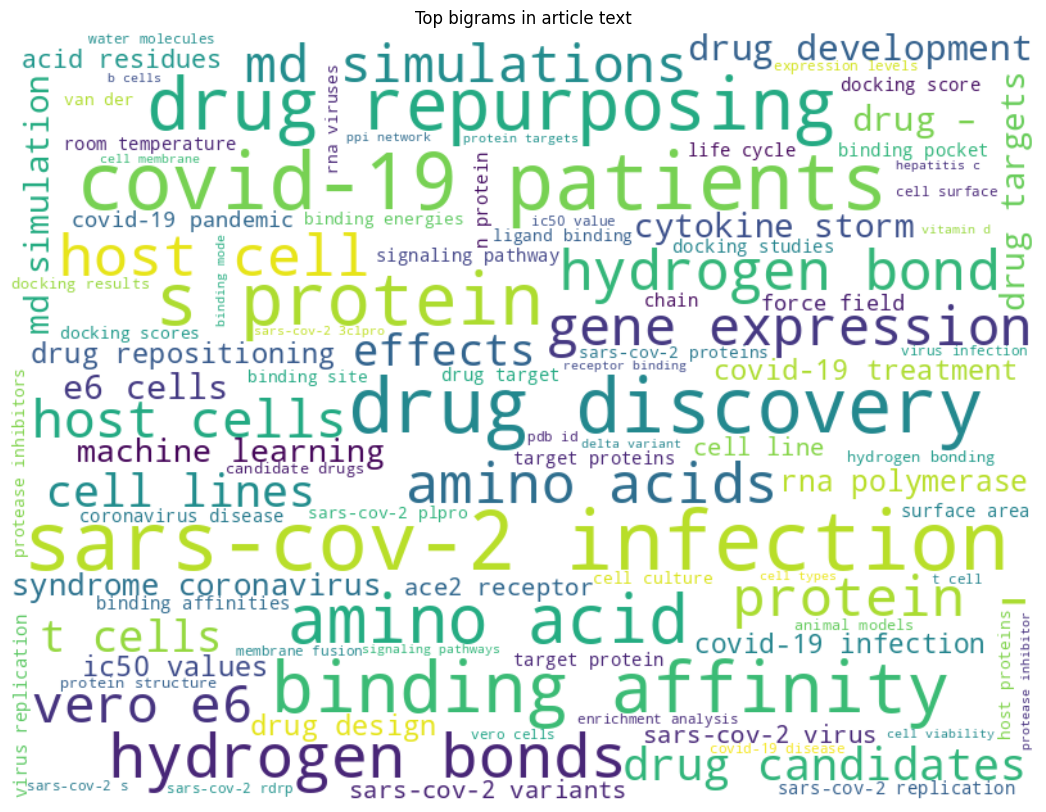

In [ ]:
title_txt = 'Top bigrams in article text'

plot_ngrams_wordcloud(bigrams_text, title_txt)

#### 5.3.5 Article title trigram wordcloud

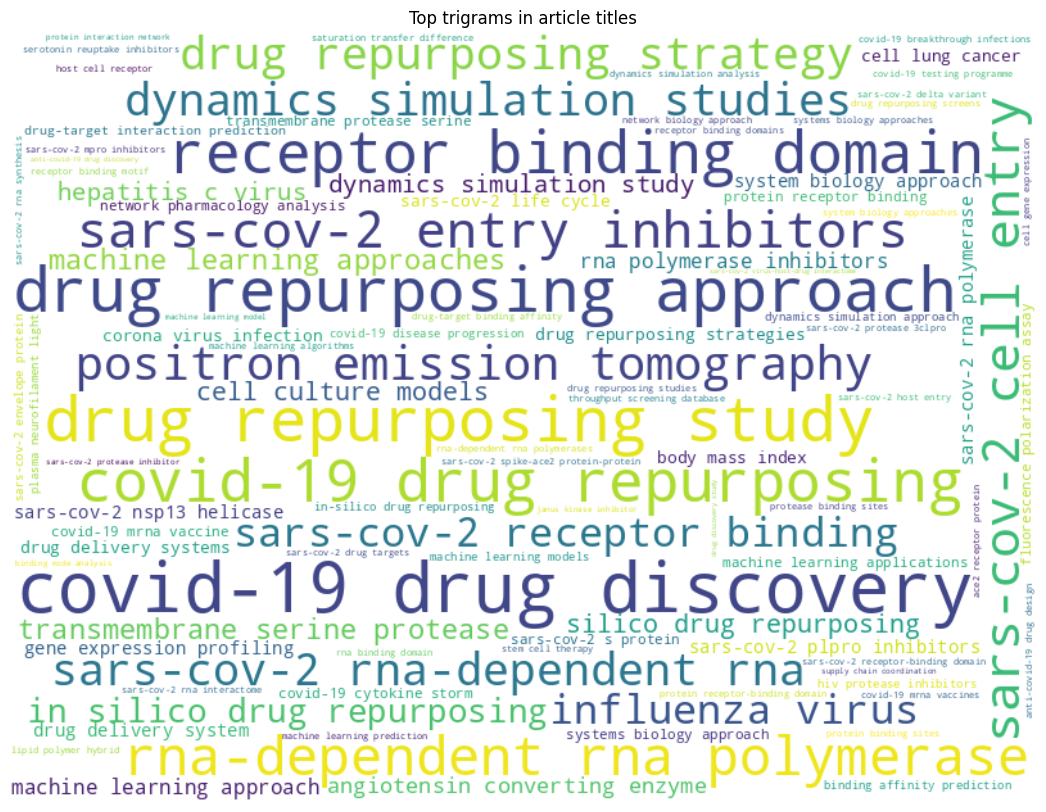

In [ ]:
title_txt = 'Top trigrams in article titles'

plot_ngrams_wordcloud(trigrams_titles, title_txt)

#### 5.3.6 Article text trigram wordcloud

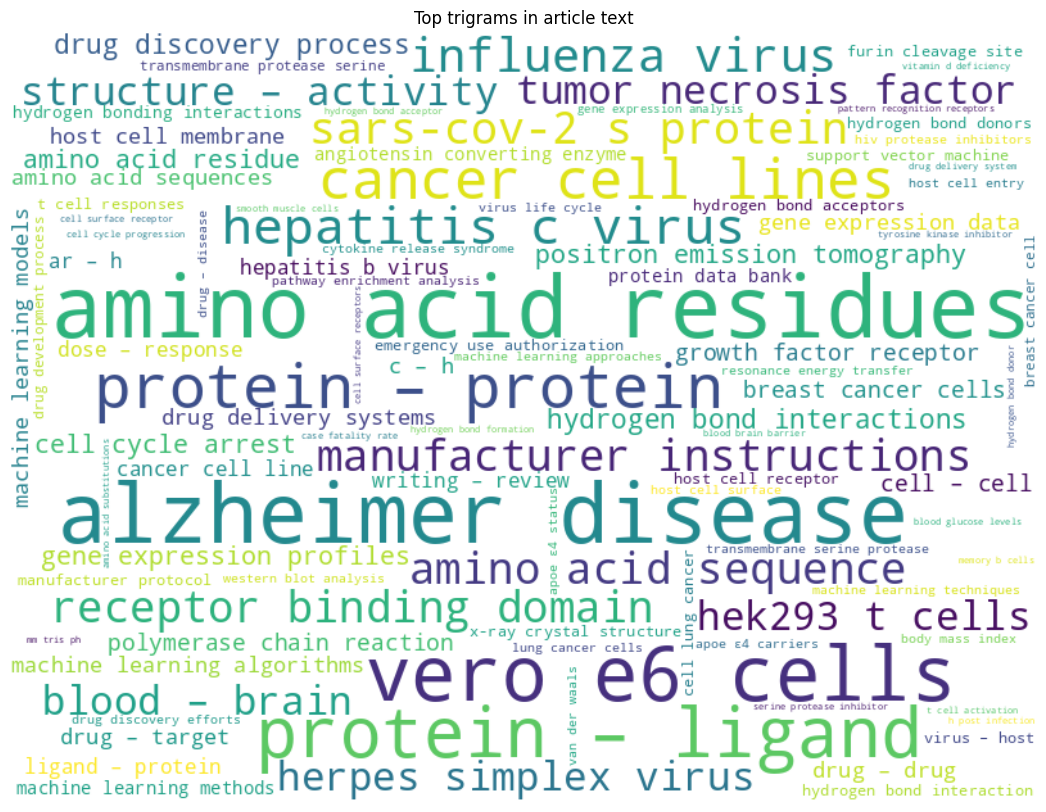

In [ ]:
title_txt = 'Top trigrams in article text'

plot_ngrams_wordcloud(trigrams_text, title_txt)

### References

- https://github.com/rsreetech/ClinicalTextClassification/blob/master/MedTextClassification.ipynb

- https://spacy.io/models

- https://machinelearningknowledge.ai/complete-guide-to-spacy-tokenizer-with-examples/#Sentence_Tokenization

- https://spacy.io/api/matcher
- https://python-textbook.pythonhumanities.com/03_spacy/03_02_03_matcher.html
- https://github.com/textstat/textstat
- https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools